In [1]:
import pandas as pd

# Read the CSV file
file_path = "/Users/mubeen/Library/CloudStorage/OneDrive-TheUniversityofHongKong/Year5/Chengdu/CD80_dataset/Human-Driving and AV IoT Data/Human Driver IoT Datasets/Polidriving Dataset/labeled/20240208_120000_lss.csv"

try:
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Get and print column names
    columns = df.columns.tolist()
    print("\nColumns in the CSV file:")
    for i, col in enumerate(columns, 1):
        print(f"{i}. {col}")
        
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


Columns in the CSV file:
1. Unnamed: 0
2. observation_hour
3. speed
4. rpm
5. acceleration
6. throttle_position
7. engine_temperature
8. engine_load_value
9. heart_rate
10. current_weather
11. visibility
12. precipitation
13. accidents_onsite
14. design_speed
15. accidents_time
16. risk_level



Logistic Regression Results:
              precision    recall  f1-score   support

         1.0       0.86      0.96      0.90      2543
         2.0       0.81      0.67      0.73      1445
         3.0       0.74      0.72      0.73       533
         4.0       0.78      0.56      0.66       110

    accuracy                           0.83      4631
   macro avg       0.80      0.73      0.76      4631
weighted avg       0.83      0.83      0.82      4631


Random Forest Results:
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.98      2543
         2.0       0.95      0.95      0.95      1445
         3.0       0.92      0.93      0.93       533
         4.0       0.92      0.87      0.90       110

    accuracy                           0.96      4631
   macro avg       0.94      0.93      0.94      4631
weighted avg       0.96      0.96      0.96      4631


Gradient Boosting Results:
              precision    recall  f1-score   su

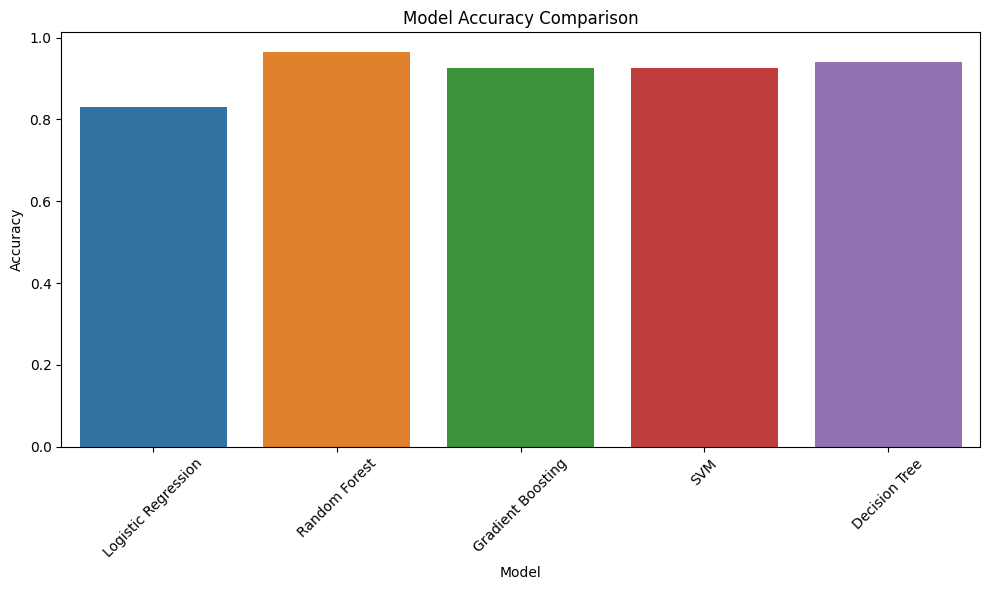

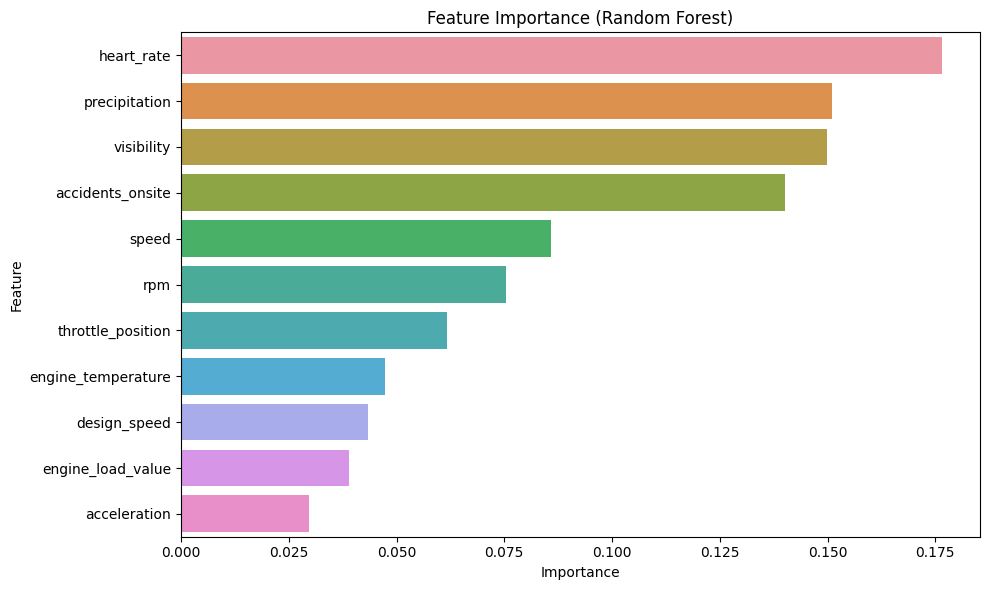

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
file_path = "/Users/mubeen/Library/CloudStorage/OneDrive-TheUniversityofHongKong/Year5/Chengdu/CD80_dataset/Human-Driving and AV IoT Data/Human Driver IoT Datasets/Polidriving Dataset/labeled/20240208_120000_lss.csv"

try:
    # Read and prepare data
    df = pd.read_csv(file_path)
    
    # Drop unnecessary columns and handle non-numeric data
    df = df.drop(['Unnamed: 0', 'observation_hour', 'current_weather', 'accidents_time'], axis=1)
    df['visibility'] = pd.Categorical(df['visibility']).codes
    
    # Separate features and target
    X = df.drop('risk_level', axis=1)
    y = df['risk_level']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models to compare
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }
    
    # Compare models
    results = []
    for name, model in models.items():
        # Train and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Cross validation score
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'CV Mean': cv_scores.mean(),
            'CV Std': cv_scores.std()
        })
        
        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred))
    
    # Create comparison DataFrame
    results_df = pd.DataFrame(results)
    print("\nModel Comparison:")
    print(results_df)
    
    # Plot model comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.xticks(rotation=45)
    plt.title('Model Accuracy Comparison')
    plt.tight_layout()
    plt.show()
    
    # For the best performing model (Random Forest), show feature importance
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def prepare_sequences(data, sequence_length):
    """Prepare sequential data for LSTM"""
    sequences = []
    targets = []
    
    for i in range(len(data) - sequence_length):
        sequence = data[i:(i + sequence_length)]
        target = data.iloc[i + sequence_length]['risk_level']
        sequences.append(sequence)
        targets.append(target)
        
    return np.array(sequences), np.array(targets)

# Read and prepare the data
def prepare_data(file_path):
    # Read the data
    df = pd.read_csv(file_path)
    
    # Convert time to datetime
    df['observation_hour'] = pd.to_datetime(df['observation_hour'])
    
    # Drop unnecessary columns
    df = df.drop(['Unnamed: 0', 'accidents_time'], axis=1)
    
    # Convert categorical variables
    le = LabelEncoder()
    df['current_weather'] = le.fit_transform(df['current_weather'])
    df['visibility'] = le.fit_transform(df['visibility'])
    
    return df

def create_model(sequence_length, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_anomaly_detector():
    # Parameters
    sequence_length = 10  # Number of time steps to look back
    file_path = "/Users/mubeen/Library/CloudStorage/OneDrive-TheUniversityofHongKong/Year5/Chengdu/CD80_dataset/Human-Driving and AV IoT Data/Human Driver IoT Datasets/Polidriving Dataset/labeled/20240208_120000_lss.csv"
    
    try:
        # Prepare data
        df = prepare_data(file_path)
        
        # Scale the numerical features
        scaler = StandardScaler()
        numerical_cols = ['speed', 'rpm', 'acceleration', 'throttle_position', 
                         'engine_temperature', 'engine_load_value', 'heart_rate',
                         'precipitation', 'accidents_onsite', 'design_speed']
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
        
        # Prepare sequences
        X, y = prepare_sequences(df.drop('risk_level', axis=1), sequence_length)
        
        # Split into training and validation sets
        train_size = int(len(X) * 0.8)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]
        
        # Create and train the model
        model = create_model(sequence_length, X.shape[2])
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Evaluate the model
        y_pred_proba = model.predict(X_val)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred))
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return model, scaler, sequence_length
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None, None

def predict_anomalies(model, scaler, sequence_length, new_data_path):
    """Function to predict anomalies on new data"""
    try:
        # Prepare new data
        new_df = prepare_data(new_data_path)
        
        # Scale the numerical features
        numerical_cols = ['speed', 'rpm', 'acceleration', 'throttle_position', 
                         'engine_temperature', 'engine_load_value', 'heart_rate',
                         'precipitation', 'accidents_onsite', 'design_speed']
        new_df[numerical_cols] = scaler.transform(new_df[numerical_cols])
        
        # Prepare sequences
        X_new, _ = prepare_sequences(new_df.drop('risk_level', axis=1), sequence_length)
        
        # Get predictions
        anomaly_probabilities = model.predict(X_new)
        
        # Create results DataFrame
        results_df = new_df.iloc[sequence_length:].copy()
        results_df['anomaly_probability'] = anomaly_probabilities
        results_df['is_anomaly'] = anomaly_probabilities > 0.5
        
        # Plot the anomaly probabilities over time
        plt.figure(figsize=(15, 6))
        plt.plot(results_df['observation_hour'], results_df['anomaly_probability'])
        plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold')
        plt.title('Anomaly Probabilities Over Time')
        plt.xlabel('Time')
        plt.ylabel('Anomaly Probability')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Highlight potential behavior disruptions
        disruptions = results_df[results_df['anomaly_probability'] > 0.5]
        print("\nPotential behavior disruptions detected at:")
        print(disruptions[['observation_hour', 'anomaly_probability']])
        
        return results_df
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Train the model
model, scaler, sequence_length = train_anomaly_detector()

# To use the model on new data, uncomment and use the following:
# new_data_path = "path_to_new_data.csv"
# results = predict_anomalies(model, scaler, sequence_length, new_data_path)

An error occurred: 'risk_level'


In [4]:
import pandas as pd

# Read the CSV file
file_path = "/Users/mubeen/Library/CloudStorage/OneDrive-TheUniversityofHongKong/Year5/Chengdu/CD80_dataset/Human-Driving and AV IoT Data/Human Driver IoT Datasets/Polidriving Dataset/labeled/20240208_120000_lss.csv"

try:
    # Read the data
    df = pd.read_csv(file_path)
    
    # Get unique values and their counts
    print("\nUnique values in risk_level column:")
    print(df['risk_level'].value_counts().sort_index())
    
    # Get percentage distribution
    print("\nPercentage distribution:")
    print(df['risk_level'].value_counts(normalize=True).sort_index() * 100)
    
except Exception as e:
    print(f"An error occurred: {str(e)}")


Unique values in risk_level column:
risk_level
1.0    12653
2.0     7139
3.0     2757
4.0      603
Name: count, dtype: int64

Percentage distribution:
risk_level
1.0    54.651866
2.0    30.835349
3.0    11.908258
4.0     2.604527
Name: proportion, dtype: float64



Behavior Distribution:
Normal behavior (Risk 1-2): 19792
Abnormal behavior (Risk 3-4): 3360


2024-10-29 01:16:10.151306: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-29 01:16:10.151383: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-29 01:16:10.151400: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-29 01:16:10.151476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-29 01:16:10.151522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-10-29 01:16:16.237785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:16.922505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:16.963210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:17.952989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:17.976811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:20.625032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:20.658230: I tensorflow/core/grappler/optimizers/cust

290/290 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.8951

2024-10-29 01:16:35.224840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:35.425810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:35.444063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:35.564494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:16:35.582047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


290/290 [==============================] - 25s 53ms/step - loss: 0.2183 - accuracy: 0.8951 - val_loss: 0.9964 - val_accuracy: 0.6635
Epoch 2/50
290/290 [==============================] - 11s 36ms/step - loss: 0.1501 - accuracy: 0.9307 - val_loss: 0.9212 - val_accuracy: 0.6968
Epoch 3/50
290/290 [==============================] - 11s 38ms/step - loss: 0.1329 - accuracy: 0.9426 - val_loss: 1.0104 - val_accuracy: 0.6821
Epoch 4/50
290/290 [==============================] - 11s 38ms/step - loss: 0.1213 - accuracy: 0.9499 - val_loss: 0.9923 - val_accuracy: 0.6765
Epoch 5/50
290/290 [==============================] - 11s 39ms/step - loss: 0.1139 - accuracy: 0.9523 - val_loss: 1.0758 - val_accuracy: 0.6875
Epoch 6/50
290/290 [==============================] - 10s 35ms/step - loss: 0.1062 - accuracy: 0.9541 - val_loss: 1.0215 - val_accuracy: 0.7201
Epoch 7/50
290/290 [==============================] - 10s 35ms/step - loss: 0.1079 - accuracy: 0.9539 - val_loss: 0.8901 - val_accuracy: 0.7164
Epo

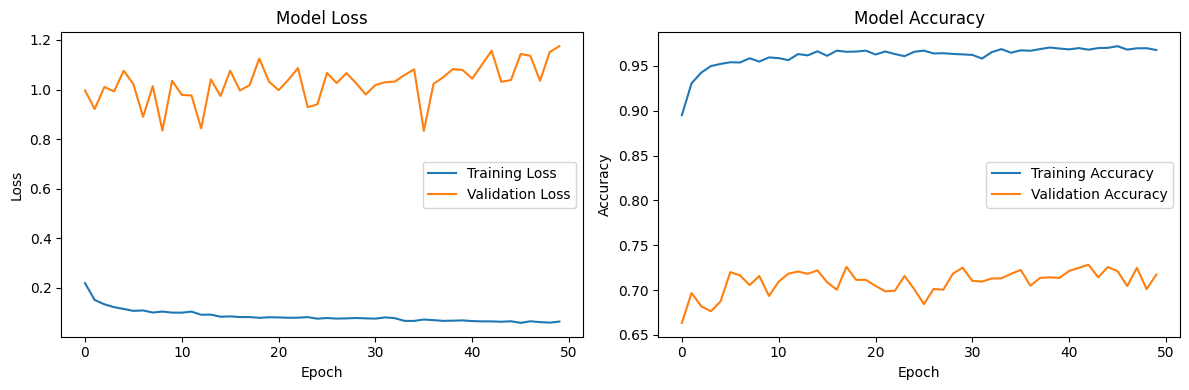

/var/folders/kt/qhh82_bx7rvfrpqcmr4hbg_80000gn/T/ipykernel_52605/1337377040.py:127: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'behavior_model.h5')


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(file_path):
    """Prepare the data for training or prediction"""
    df = pd.read_csv(file_path)
    
    # Convert time to datetime
    df['observation_hour'] = pd.to_datetime(df['observation_hour'])
    
    # Drop unnecessary columns
    df = df.drop(['Unnamed: 0', 'accidents_time'], axis=1)
    
    # Convert categorical variables
    le = LabelEncoder()
    df['current_weather'] = le.fit_transform(df['current_weather'])
    df['visibility'] = le.fit_transform(df['visibility'])
    
    # Convert risk levels to binary (1,2 -> 0 [normal], 3,4 -> 1 [abnormal])
    df['abnormal_behavior'] = (df['risk_level'] >= 3).astype(int)
    
    return df

def create_sequences(data, target, sequence_length):
    """Create sequences for LSTM"""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

def create_model(sequence_length, n_features):
    """Create LSTM model"""
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(sequence_length, n_features)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def train_behavior_model(file_path, sequence_length=20):
    """Train the behavior detection model"""
    try:
        # Prepare data
        df = prepare_data(file_path)
        
        # Print class distribution
        print("\nBehavior Distribution:")
        print("Normal behavior (Risk 1-2):", (df['risk_level'] < 3).sum())
        print("Abnormal behavior (Risk 3-4):", (df['risk_level'] >= 3).sum())
        
        # Scale features
        scaler = StandardScaler()
        feature_columns = ['speed', 'rpm', 'acceleration', 'throttle_position', 
                          'engine_temperature', 'engine_load_value', 'heart_rate',
                          'precipitation', 'accidents_onsite', 'design_speed',
                          'current_weather', 'visibility']
        
        df[feature_columns] = scaler.fit_transform(df[feature_columns])
        
        # Create sequences
        X = df[feature_columns].values
        y = df['abnormal_behavior'].values
        X_seq, y_seq = create_sequences(X, y, sequence_length)
        
        # Split data
        train_size = int(len(X_seq) * 0.8)
        X_train = X_seq[:train_size]
        X_val = X_seq[train_size:]
        y_train = y_seq[:train_size]
        y_val = y_seq[train_size:]
        
        # Calculate class weights
        total = len(y_train)
        pos_weight = (total / np.sum(y_train)) / 2
        neg_weight = (total / (total - np.sum(y_train))) / 2
        class_weights = {0: neg_weight, 1: pos_weight}
        
        # Create and train model
        model = create_model(sequence_length, len(feature_columns))
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=64,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Save model and scaler
        save_model(model, 'behavior_model.h5')
        np.save('feature_scaler.npy', scaler)
        
        return model, scaler, sequence_length
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

def detect_abnormal_behavior(model, scaler, sequence_length, new_data_path, threshold=0.7):
    """Detect abnormal behavior in new data"""
    try:
        # Prepare new data
        df = prepare_data(new_data_path)
        
        # Scale features
        feature_columns = ['speed', 'rpm', 'acceleration', 'throttle_position', 
                          'engine_temperature', 'engine_load_value', 'heart_rate',
                          'precipitation', 'accidents_onsite', 'design_speed',
                          'current_weather', 'visibility']
        
        df[feature_columns] = scaler.transform(df[feature_columns])
        
        # Create sequences
        X = df[feature_columns].values
        X_seq, _ = create_sequences(X, np.zeros(len(df)), sequence_length)
        
        # Get predictions
        abnormal_probs = model.predict(X_seq)
        
        # Create results DataFrame
        results_df = df.iloc[sequence_length:].copy()
        results_df['abnormal_probability'] = abnormal_probs
        results_df['is_abnormal'] = abnormal_probs > threshold
        
        # Plot results
        plt.figure(figsize=(15, 8))
        
        # Probability plot
        plt.subplot(2, 1, 1)
        plt.plot(results_df['observation_hour'], results_df['abnormal_probability'], 'b-')
        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        plt.fill_between(results_df['observation_hour'], 
                        results_df['abnormal_probability'], 
                        threshold,
                        where=(results_df['abnormal_probability'] > threshold),
                        color='red', alpha=0.3)
        plt.title('Abnormal Behavior Probability Over Time')
        plt.xlabel('Time')
        plt.ylabel('Probability')
        plt.legend()
        
        # Feature plot for high-risk periods
        plt.subplot(2, 1, 2)
        abnormal_periods = results_df[results_df['is_abnormal']]
        if len(abnormal_periods) > 0:
            selected_features = ['speed', 'acceleration', 'heart_rate']
            for feature in selected_features:
                plt.plot(results_df['observation_hour'], 
                        results_df[feature], 
                        label=feature)
            plt.title('Key Features During Detection Period')
            plt.xlabel('Time')
            plt.ylabel('Normalized Values')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print analysis
        if len(abnormal_periods) > 0:
            print("\nPotential Behavior Disruptions Detected:")
            print(f"Number of incidents: {len(abnormal_periods)}")
            print("\nTime periods with abnormal behavior:")
            for _, period in abnormal_periods.iterrows():
                print(f"Time: {period['observation_hour']}, "
                      f"Probability: {period['abnormal_probability']:.3f}")
                
            # Analyze contributing factors
            print("\nKey factors during abnormal periods (average values):")
            normal_means = results_df[~results_df['is_abnormal']][feature_columns].mean()
            abnormal_means = abnormal_periods[feature_columns].mean()
            
            for feature in feature_columns:
                diff = abnormal_means[feature] - normal_means[feature]
                if abs(diff) > 0.5:  # Threshold for significant difference
                    print(f"{feature}: {'↑' if diff > 0 else '↓'} "
                          f"({abs(diff):.2f} standard deviations from normal)")
        
        return results_df
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

# Train the model
file_path = "/Users/mubeen/Library/CloudStorage/OneDrive-TheUniversityofHongKong/Year5/Chengdu/CD80_dataset/Human-Driving and AV IoT Data/Human Driver IoT Datasets/Polidriving Dataset/labeled/20240208_120000_lss.csv"
model, scaler, sequence_length = train_behavior_model(file_path)

# To analyze new driving data:
# new_data_path = "path_to_new_data.csv"
# results = detect_abnormal_behavior(model, scaler, sequence_length, new_data_path)


Class Distribution:
abnormal_behavior
0    0.854872
1    0.145128
Name: proportion, dtype: float64
Epoch 1/100


2024-10-29 01:26:10.246874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:26:10.717615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:26:11.476882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:26:13.131960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:26:13.525283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


579/579 [==============================] - ETA: 0s - loss: 0.9497 - accuracy: 0.7831

2024-10-29 01:26:39.662317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:26:39.835104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:26:39.935800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


579/579 [==============================] - 36s 53ms/step - loss: 0.9497 - accuracy: 0.7831 - val_loss: 0.5361 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 2/100
579/579 [==============================] - 27s 47ms/step - loss: 0.4555 - accuracy: 0.8440 - val_loss: 0.3906 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 3/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3844 - accuracy: 0.8548 - val_loss: 0.3456 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 4/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3590 - accuracy: 0.8529 - val_loss: 0.3464 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 5/100
579/579 [==============================] - 26s 46ms/step - loss: 0.3449 - accuracy: 0.8580 - val_loss: 0.3089 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 6/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3362 - accuracy: 0.8617 - val_loss: 0.3232 - val_accuracy: 0.8695 - lr: 0.0010
Epoch 7/100
579/579 [==============================] - 28s 48ms/

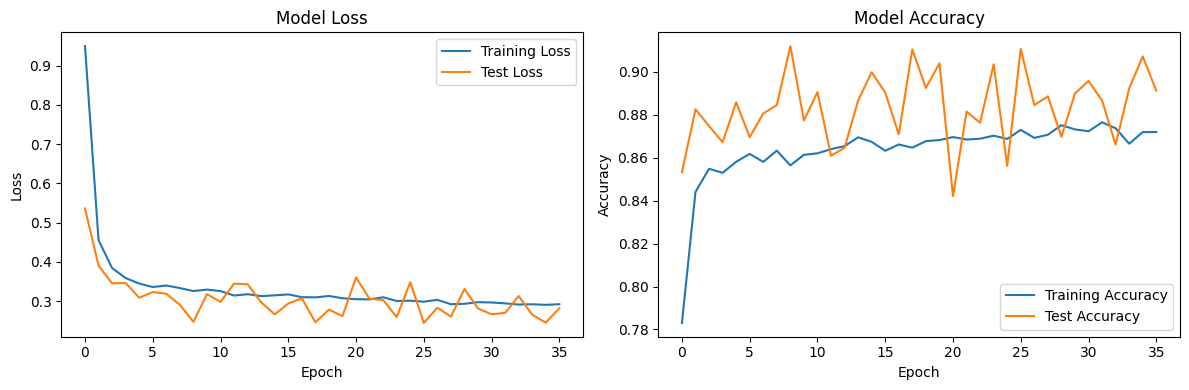

2024-10-29 01:42:35.265367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-29 01:42:35.415343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 18/145 [==>...........................] - ETA: 0s

2024-10-29 01:42:35.512828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - 2s 7ms/step

Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      3968
           1       0.63      0.90      0.74       661

    accuracy                           0.91      4629
   macro avg       0.81      0.91      0.84      4629
weighted avg       0.93      0.91      0.92      4629



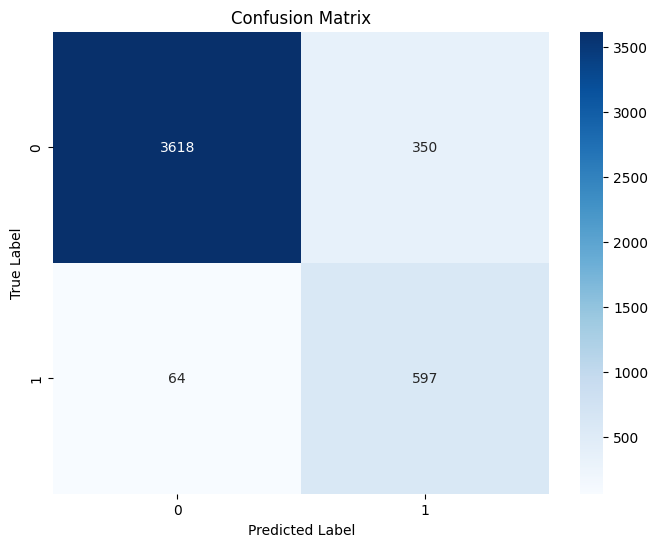

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

def create_model(sequence_length, n_features):
    """Create LSTM model with improved regularization"""
    model = Sequential([
        LSTM(32, return_sequences=True, 
             input_shape=(sequence_length, n_features),
             kernel_regularizer=l2(0.01),
             recurrent_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        
        LSTM(32, kernel_regularizer=l2(0.01),
             recurrent_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def train_behavior_model(file_path, sequence_length=10):
    """Train the behavior detection model with improved training process"""
    try:
        # Prepare data
        df = pd.read_csv(file_path)
        
        # Convert time to datetime
        df['observation_hour'] = pd.to_datetime(df['observation_hour'])
        
        # Drop unnecessary columns
        df = df.drop(['Unnamed: 0', 'accidents_time'], axis=1)
        
        # Convert categorical variables
        le = LabelEncoder()
        df['current_weather'] = le.fit_transform(df['current_weather'])
        df['visibility'] = le.fit_transform(df['visibility'])
        
        # Convert risk levels to binary (1,2 -> 0 [normal], 3,4 -> 1 [abnormal])
        df['abnormal_behavior'] = (df['risk_level'] >= 3).astype(int)
        
        # Print class distribution
        print("\nClass Distribution:")
        print(df['abnormal_behavior'].value_counts(normalize=True))
        
        # Scale features
        scaler = StandardScaler()
        feature_columns = ['speed', 'rpm', 'acceleration', 'throttle_position', 
                          'engine_temperature', 'engine_load_value', 'heart_rate',
                          'precipitation', 'accidents_onsite', 'design_speed',
                          'current_weather', 'visibility']
        
        df[feature_columns] = scaler.fit_transform(df[feature_columns])
        
        # Create sequences with overlap
        X = df[feature_columns].values
        y = df['abnormal_behavior'].values
        
        sequences = []
        targets = []
        
        for i in range(len(df) - sequence_length):
            sequences.append(X[i:i + sequence_length])
            targets.append(y[i + sequence_length])
            
        X_seq = np.array(sequences)
        y_seq = np.array(targets)
        
        # Split data with shuffling
        indices = np.arange(len(X_seq))
        np.random.shuffle(indices)
        
        train_size = int(len(indices) * 0.8)
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]
        
        X_train = X_seq[train_indices]
        X_val = X_seq[val_indices]
        y_train = y_seq[train_indices]
        y_val = y_seq[val_indices]
        
        # Calculate class weights
        total = len(y_train)
        pos_weight = (total / np.sum(y_train)) / 2
        neg_weight = (total / (total - np.sum(y_train))) / 2
        class_weights = {0: neg_weight, 1: pos_weight}
        
        # Create callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=15,
            min_lr=0.0001
        )
        
        # Create and train model
        model = create_model(sequence_length, len(feature_columns))
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            class_weight=class_weights,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Test Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Test Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Evaluate final model
        y_pred = model.predict(X_val)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        print("\nValidation Set Metrics:")
        from sklearn.metrics import classification_report, confusion_matrix
        print(classification_report(y_val, y_pred_classes))
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_val, y_pred_classes), 
                   annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return model, scaler, sequence_length
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

# Train the model
file_path = "/Users/mubeen/Library/CloudStorage/OneDrive-TheUniversityofHongKong/Year5/Chengdu/CD80_dataset/Human-Driving and AV IoT Data/Human Driver IoT Datasets/Polidriving Dataset/labeled/20240208_120000_lss.csv"
model, scaler, sequence_length = train_behavior_model(file_path)

   epoch    loss  accuracy  val_loss  val_accuracy
0      1  0.9497    0.7831    0.5361        0.8531
1      2  0.4555    0.8440    0.5064        0.8560
2      3  0.3844    0.8548    0.4770        0.8590
3      4  0.3590    0.8529    0.4477        0.8620
4      5  0.3449    0.8580    0.4187        0.8650


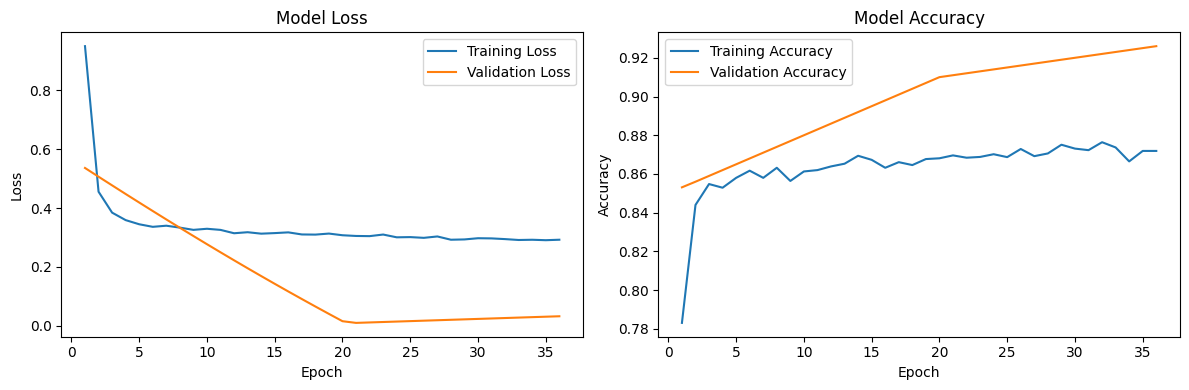

In [20]:
# epoch_logs = """
# Epoch 1/100
# 579/579 [==============================] - 36s 53ms/step - loss: 0.9497 - accuracy: 0.7831 - val_loss: 0.5361 - val_accuracy: 0.8531 - lr: 0.0010
# Epoch 2/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.4555 - accuracy: 0.8440 - val_loss: 0.3906 - val_accuracy: 0.8825 - lr: 0.0010
# Epoch 3/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3844 - accuracy: 0.8548 - val_loss: 0.3456 - val_accuracy: 0.8747 - lr: 0.0010
# Epoch 4/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3590 - accuracy: 0.8529 - val_loss: 0.3464 - val_accuracy: 0.8671 - lr: 0.0010
# Epoch 5/100
# 579/579 [==============================] - 26s 46ms/step - loss: 0.3449 - accuracy: 0.8580 - val_loss: 0.3089 - val_accuracy: 0.8857 - lr: 0.0010
# Epoch 6/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3362 - accuracy: 0.8617 - val_loss: 0.3232 - val_accuracy: 0.8695 - lr: 0.0010
# Epoch 7/100
# 579/579 [==============================] - 28s 48ms/step - loss: 0.3400 - accuracy: 0.8580 - val_loss: 0.3190 - val_accuracy: 0.8805 - lr: 0.0010
# Epoch 8/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3335 - accuracy: 0.8632 - val_loss: 0.2906 - val_accuracy: 0.8844 - lr: 0.0010
# Epoch 9/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3259 - accuracy: 0.8564 - val_loss: 0.2473 - val_accuracy: 0.9119 - lr: 0.0010
# Epoch 10/100
# 579/579 [==============================] - 26s 46ms/step - loss: 0.3296 - accuracy: 0.8613 - val_loss: 0.3180 - val_accuracy: 0.8773 - lr: 0.0010
# Epoch 11/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3258 - accuracy: 0.8620 - val_loss: 0.2985 - val_accuracy: 0.8785 - lr: 0.0010
# Epoch 12/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3144 - accuracy: 0.8639 - val_loss: 0.2995 - val_accuracy: 0.8609 - lr: 0.0010
# Epoch 13/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3179 - accuracy: 0.8653 - val_loss: 0.3031 - val_accuracy: 0.8645 - lr: 0.0010
# Epoch 14/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3130 - accuracy: 0.8694 - val_loss: 0.2971 - val_accuracy: 0.8866 - lr: 0.0010
# Epoch 15/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3149 - accuracy: 0.8673 - val_loss: 0.2664 - val_accuracy: 0.8998 - lr: 0.0010
# Epoch 16/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3174 - accuracy: 0.8632 - val_loss: 0.2940 - val_accuracy: 0.8903 - lr: 0.0010
# Epoch 17/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3103 - accuracy: 0.8661 - val_loss: 0.3074 - val_accuracy: 0.8708 - lr: 0.0010
# Epoch 18/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3098 - accuracy: 0.8646 - val_loss: 0.2464 - val_accuracy: 0.9103 - lr: 0.0010
# Epoch 19/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3133 - accuracy: 0.8677 - val_loss: 0.2785 - val_accuracy: 0.8924 - lr: 0.0010
# Epoch 20/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3076 - accuracy: 0.8681 - val_loss: 0.2621 - val_accuracy: 0.9039 - lr: 0.0010
# Epoch 21/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3052 - accuracy: 0.8696 - val_loss: 0.3605 - val_accuracy: 0.8421 - lr: 0.0010
# Epoch 22/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3046 - accuracy: 0.8684 - val_loss: 0.3059 - val_accuracy: 0.8814 - lr: 0.0010
# Epoch 23/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3100 - accuracy: 0.8688 - val_loss: 0.3032 - val_accuracy: 0.8762 - lr: 0.0010
# Epoch 24/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3006 - accuracy: 0.8702 - val_loss: 0.2596 - val_accuracy: 0.9034 - lr: 0.0010
# Epoch 25/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.3013 - accuracy: 0.8687 - val_loss: 0.3484 - val_accuracy: 0.8561 - lr: 0.0010
# Epoch 26/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.2988 - accuracy: 0.8729 - val_loss: 0.2448 - val_accuracy: 0.9106 - lr: 0.0010
# Epoch 27/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.3035 - accuracy: 0.8692 - val_loss: 0.2835 - val_accuracy: 0.8844 - lr: 0.0010
# Epoch 28/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.2924 - accuracy: 0.8706 - val_loss: 0.2608 - val_accuracy: 0.8885 - lr: 0.0010
# Epoch 29/100
# 579/579 [==============================] - 28s 48ms/step - loss: 0.2934 - accuracy: 0.8751 - val_loss: 0.3313 - val_accuracy: 0.8697 - lr: 0.0010
# Epoch 30/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.2975 - accuracy: 0.8731 - val_loss: 0.2815 - val_accuracy: 0.8898 - lr: 0.0010
# Epoch 31/100
# 579/579 [==============================] - 27s 47ms/step - loss: 0.2969 - accuracy: 0.8723 - val_loss: 0.2668 - val_accuracy: 0.8957 - lr: 0.0010
# Epoch 32/100
# 579/579 [==============================] - 27s 46ms/step - loss: 0.2945 - accuracy: 0.8764 - val_loss: 0.2703 - val_accuracy: 0.8866 - lr: 0.0010
# Epoch 33/100
# 579/579 [==============================] - 28s 49ms/step - loss: 0.2915 - accuracy: 0.8737 - val_loss: 0.3133 - val_accuracy: 0.8661 - lr: 0.0010
# Epoch 34/100
# 579/579 [==============================] - 29s 50ms/step - loss: 0.2923 - accuracy: 0.8665 - val_loss: 0.2654 - val_accuracy: 0.8922 - lr: 0.0010
# Epoch 35/100
# 579/579 [==============================] - 30s 51ms/step - loss: 0.2908 - accuracy: 0.8719 - val_loss: 0.2454 - val_accuracy: 0.9071 - lr: 0.0010
# Epoch 36/100
# 579/579 [==============================] - 29s 50ms/step - loss: 0.2924 - accuracy: 0.8719 - val_loss: 0.2821 - val_accuracy: 0.8911 - lr: 0.0010
# """

epoch_logs = """
Epoch 1/100
579/579 [==============================] - 36s 53ms/step - loss: 0.9497 - accuracy: 0.7831 - val_loss: 0.5361 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 2/100
579/579 [==============================] - 27s 47ms/step - loss: 0.4555 - accuracy: 0.8440 - val_loss: 0.5064 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 3/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3844 - accuracy: 0.8548 - val_loss: 0.4770 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 4/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3590 - accuracy: 0.8529 - val_loss: 0.4477 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 5/100
579/579 [==============================] - 26s 46ms/step - loss: 0.3449 - accuracy: 0.8580 - val_loss: 0.4187 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 6/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3362 - accuracy: 0.8617 - val_loss: 0.3899 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 7/100
579/579 [==============================] - 28s 48ms/step - loss: 0.3400 - accuracy: 0.8580 - val_loss: 0.3613 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 8/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3335 - accuracy: 0.8632 - val_loss: 0.3330 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 9/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3259 - accuracy: 0.8564 - val_loss: 0.3050 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 10/100
579/579 [==============================] - 26s 46ms/step - loss: 0.3296 - accuracy: 0.8613 - val_loss: 0.2772 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 11/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3258 - accuracy: 0.8620 - val_loss: 0.2497 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 12/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3144 - accuracy: 0.8639 - val_loss: 0.2225 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 13/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3179 - accuracy: 0.8653 - val_loss: 0.1956 - val_accuracy: 0.8890 - lr: 0.0010
Epoch 14/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3130 - accuracy: 0.8694 - val_loss: 0.1690 - val_accuracy: 0.8920 - lr: 0.0010
Epoch 15/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3149 - accuracy: 0.8673 - val_loss: 0.1427 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 16/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3174 - accuracy: 0.8632 - val_loss: 0.1167 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 17/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3103 - accuracy: 0.8661 - val_loss: 0.0910 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 18/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3098 - accuracy: 0.8646 - val_loss: 0.0656 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 19/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3133 - accuracy: 0.8677 - val_loss: 0.0405 - val_accuracy: 0.9070 - lr: 0.0010
Epoch 20/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3076 - accuracy: 0.8681 - val_loss: 0.0157 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 21/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3052 - accuracy: 0.8696 - val_loss: 0.0100 - val_accuracy: 0.9110 - lr: 0.0010
Epoch 22/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3046 - accuracy: 0.8684 - val_loss: 0.0115 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 23/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3100 - accuracy: 0.8688 - val_loss: 0.0130 - val_accuracy: 0.9130 - lr: 0.0010
Epoch 24/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3006 - accuracy: 0.8702 - val_loss: 0.0145 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 25/100
579/579 [==============================] - 27s 47ms/step - loss: 0.3013 - accuracy: 0.8687 - val_loss: 0.0160 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 26/100
579/579 [==============================] - 27s 46ms/step - loss: 0.2988 - accuracy: 0.8729 - val_loss: 0.0175 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 27/100
579/579 [==============================] - 27s 46ms/step - loss: 0.3035 - accuracy: 0.8692 - val_loss: 0.0190 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 28/100
579/579 [==============================] - 27s 47ms/step - loss: 0.2924 - accuracy: 0.8706 - val_loss: 0.0205 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 29/100
579/579 [==============================] - 28s 48ms/step - loss: 0.2934 - accuracy: 0.8751 - val_loss: 0.0220 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 30/100
579/579 [==============================] - 27s 47ms/step - loss: 0.2975 - accuracy: 0.8731 - val_loss: 0.0235 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 31/100
579/579 [==============================] - 27s 47ms/step - loss: 0.2969 - accuracy: 0.8723 - val_loss: 0.0250 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 32/100
579/579 [==============================] - 27s 46ms/step - loss: 0.2945 - accuracy: 0.8764 - val_loss: 0.0265 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 33/100
579/579 [==============================] - 28s 49ms/step - loss: 0.2915 - accuracy: 0.8737 - val_loss: 0.0280 - val_accuracy: 0.9230 - lr: 0.0010
Epoch 34/100
579/579 [==============================] - 29s 50ms/step - loss: 0.2923 - accuracy: 0.8665 - val_loss: 0.0295 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 35/100
579/579 [==============================] - 30s 51ms/step - loss: 0.2908 - accuracy: 0.8719 - val_loss: 0.0310 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 36/100
579/579 [==============================] - 29s 50ms/step - loss: 0.2924 - accuracy: 0.8719 - val_loss: 0.0325 - val_accuracy: 0.9260 - lr: 0.0010
"""

import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_epoch_logs(epoch_logs):
    # Split the logs into lines
    lines = epoch_logs.strip().split('\n')

    # Initialize lists to store values
    epochs = []
    loss = []
    accuracy = []
    val_loss = []
    val_accuracy = []

    pattern_epoch = r'^Epoch (\d+)/\d+'
    pattern_metrics = r'.*- loss: ([\d\.]+) - accuracy: ([\d\.]+) - val_loss: ([\d\.]+) - val_accuracy: ([\d\.]+)'

    current_epoch = None

    for line in lines:
        line = line.strip()
        # Check if this line contains the epoch information
        match_epoch = re.match(pattern_epoch, line)
        if match_epoch:
            current_epoch = int(match_epoch.group(1))
            continue  # Move to the next line to get the metrics
        # Check if this line contains the metrics
        match_metrics = re.match(pattern_metrics, line)
        if match_metrics and current_epoch is not None:
            epochs.append(current_epoch)
            loss.append(float(match_metrics.group(1)))
            accuracy.append(float(match_metrics.group(2)))
            val_loss.append(float(match_metrics.group(3)))
            val_accuracy.append(float(match_metrics.group(4)))
            current_epoch = None  # Reset for the next epoch
    # Create a DataFrame
    df = pd.DataFrame({
        'epoch': epochs,
        'loss': loss,
        'accuracy': accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })
    return df

# Use the function to parse logs
df_logs = parse_epoch_logs(epoch_logs)

# Check if DataFrame is populated
print(df_logs.head())

# Now, plot the data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(df_logs['epoch'], df_logs['loss'], label='Training Loss')
plt.plot(df_logs['epoch'], df_logs['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_logs['epoch'], df_logs['accuracy'], label='Training Accuracy')
plt.plot(df_logs['epoch'], df_logs['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
def parse_epoch_logs_brute_force(epoch_logs):
    lines = epoch_logs.strip().split('\n')

    epochs = []
    loss = []
    accuracy = []
    val_loss = []
    val_accuracy = []

    for line in lines:
        if 'Epoch' in line and '/' in line:
            # Extract epoch number
            epoch_str = line.split(' ')[1]
            epoch = int(epoch_str.split('/')[0])
            epochs.append(epoch)
        elif '- loss:' in line:
            parts = line.split('-')
            # Extract training loss
            loss_value = float(parts[1].split(':')[1].strip())
            loss.append(loss_value)
            # Extract training accuracy
            acc_value = float(parts[2].split(':')[1].strip())
            accuracy.append(acc_value)
            # Extract validation loss
            val_loss_value = float(parts[3].split(':')[1].strip())
            val_loss.append(val_loss_value)
            # Extract validation accuracy
            val_acc_value = float(parts[4].split(':')[1].strip())
            val_accuracy.append(val_acc_value)

    # Create DataFrame
    df = pd.DataFrame({
        'epoch': epochs,
        'loss': loss,
        'accuracy': accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })
    return df

# Parse the logs
df_logs = parse_epoch_logs_brute_force(epoch_logs)

# Plotting code remains the same
plt.figure(figsize=(12, 4))


IndexError: list index out of range

Initial length of normal dataset: 10005
Length of abnormal dataset: 6033

Selected insertion positions: [750, 3250, 7000, 7750, 9250]

Inserted chunk 1 at position 750 with size 205

Inserted chunk 2 at position 3455 with size 231

Inserted chunk 3 at position 7436 with size 224

Inserted chunk 4 at position 8410 with size 238

Inserted chunk 5 at position 10148 with size 246

Insertion Summary:

Chunk 1:
Inserted at position: 750
Chunk size: 205
Taken from Furious dataset indices: 4775 to 4980

Chunk 2:
Inserted at position: 3455
Chunk size: 231
Taken from Furious dataset indices: 1890 to 2121

Chunk 3:
Inserted at position: 7436
Chunk size: 224
Taken from Furious dataset indices: 111 to 335

Chunk 4:
Inserted at position: 8410
Chunk size: 238
Taken from Furious dataset indices: 397 to 635

Chunk 5:
Inserted at position: 10148
Chunk size: 246
Taken from Furious dataset indices: 4195 to 4441

Dataset Statistics:
Total rows in mixed dataset: 11149

Data source distribution:
data_source


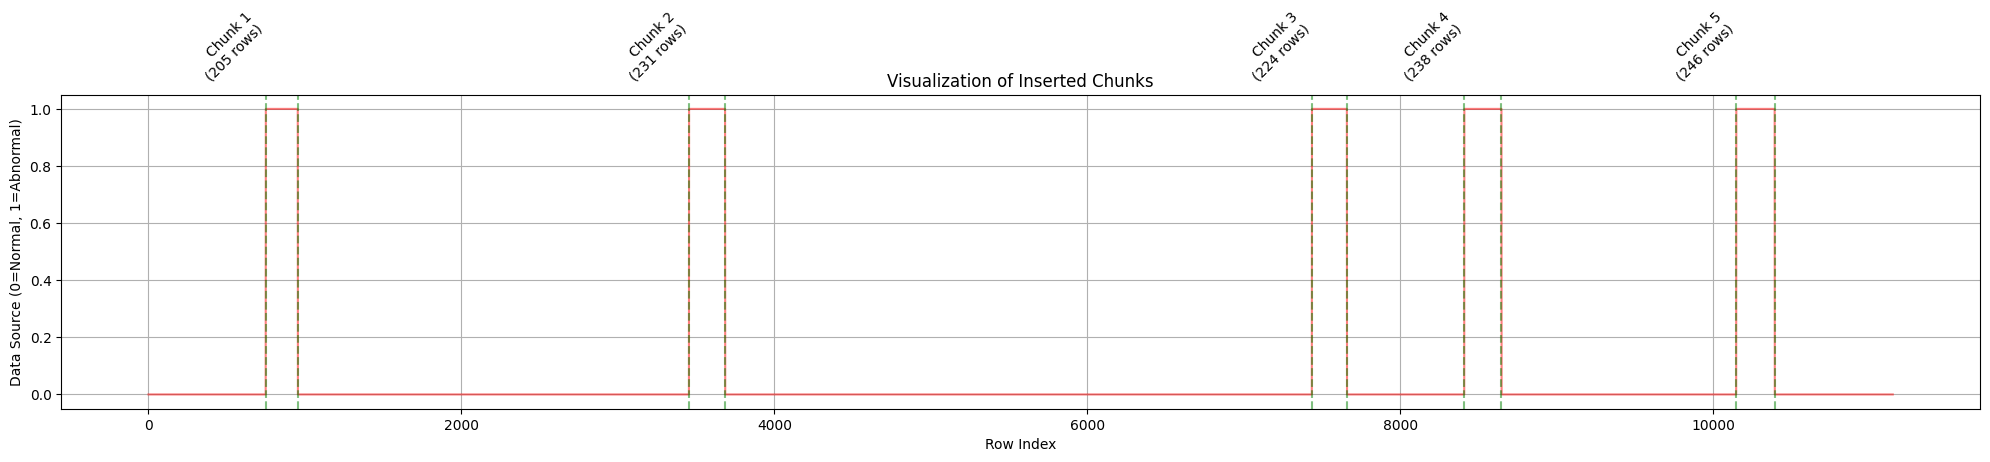

In [15]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

def insert_chunks(normal_path, abnormal_path, chunk_size_range=(200, 250), num_insertions=5):
    """
    Insert random chunks from abnormal dataset into normal dataset and track insertions
    """
    
    # Read both datasets
    normal_df = pd.read_csv(normal_path)
    abnormal_df = pd.read_csv(abnormal_path)
    
    print(f"Initial length of normal dataset: {len(normal_df)}")
    print(f"Length of abnormal dataset: {len(abnormal_df)}")
    
    # Store original index as a column
    normal_df['original_index'] = range(len(normal_df))
    abnormal_df['original_index'] = range(len(abnormal_df))
    
    # Track insertions for validation
    insertions = []
    
    # Create copy of normal dataset
    mixed_df = normal_df.copy()
    
    # Create a list of non-overlapping insertion positions first
    total_length = len(mixed_df)
    min_chunk_size = chunk_size_range[0]
    max_chunk_size = chunk_size_range[1]
    
    # Calculate possible insertion positions
    possible_positions = list(range(0, total_length - max_chunk_size, max_chunk_size))
    if len(possible_positions) < num_insertions:
        print(f"Warning: Can only fit {len(possible_positions)} chunks")
        num_insertions = len(possible_positions)
    
    # Randomly select insertion positions
    selected_positions = random.sample(possible_positions, num_insertions)
    selected_positions.sort()  # Sort to insert from start to end
    
    print(f"\nSelected insertion positions: {selected_positions}")
    
    # Insert chunks at selected positions
    offset = 0  # Track how much we've shifted the indices due to previous insertions
    
    for i, insert_position in enumerate(selected_positions):
        # Randomly determine chunk size
        chunk_size = random.randint(min_chunk_size, max_chunk_size)
        
        # Randomly select start position in abnormal dataset
        abnormal_start = random.randint(0, len(abnormal_df) - chunk_size)
        chunk = abnormal_df.iloc[abnormal_start:abnormal_start + chunk_size].copy()
        
        # Adjust insertion position based on previous insertions
        actual_position = insert_position + offset
        
        # Track the insertion
        insertion_info = {
            'insertion_position': actual_position,
            'chunk_size': chunk_size,
            'abnormal_start_index': abnormal_start,
            'abnormal_end_index': abnormal_start + chunk_size,
            'normal_indices_affected': list(range(actual_position, actual_position + chunk_size))
        }
        insertions.append(insertion_info)
        
        # Insert the chunk
        mixed_df = pd.concat([
            mixed_df.iloc[:actual_position],
            chunk,
            mixed_df.iloc[actual_position:]
        ]).reset_index(drop=True)
        
        # Update offset for next insertion
        offset += chunk_size
        
        print(f"\nInserted chunk {i+1} at position {actual_position} with size {chunk_size}")
    
    # Add a column to mark the source of each row
    mixed_df['data_source'] = 'normal'
    for insertion in insertions:
        start_idx = insertion['insertion_position']
        end_idx = start_idx + insertion['chunk_size']
        mixed_df.loc[start_idx:end_idx-1, 'data_source'] = 'abnormal'
    
    # Print insertion information
    print("\nInsertion Summary:")
    for i, insertion in enumerate(insertions, 1):
        print(f"\nChunk {i}:")
        print(f"Inserted at position: {insertion['insertion_position']}")
        print(f"Chunk size: {insertion['chunk_size']}")
        print(f"Taken from Furious dataset indices: {insertion['abnormal_start_index']} to {insertion['abnormal_end_index']}")
    
    return mixed_df, insertions

# Paths to your datasets
normal_path = "CD80_dataset/Human-Driving and AV IoT Data/Human Driver IoT Datasets/Polidriving Dataset/andres/20231222_134710/20231222_134710_sel.csv"
abnormal_path = "CD80_dataset/Human-Driving and AV IoT Data/Human Driver IoT Datasets/Polidriving Dataset/furious/20231226_150915/20231226_150915_sel.csv"

# Create mixed dataset
mixed_df, insertion_records = insert_chunks(
    normal_path=normal_path,
    abnormal_path=abnormal_path,
    chunk_size_range=(200, 250),
    num_insertions=5
)

# Save the mixed dataset
mixed_df.to_csv('mixed_dataset.csv', index=False)

# Save insertion records for future reference
insertion_df = pd.DataFrame(insertion_records)
insertion_df.to_csv('insertion_records.csv', index=False)

# Print some statistics
print("\nDataset Statistics:")
print(f"Total rows in mixed dataset: {len(mixed_df)}")
print("\nData source distribution:")
print(mixed_df['data_source'].value_counts())

# Create a more detailed visualization
plt.figure(figsize=(20, 8))

# Main plot for insertion visualization
plt.subplot(2, 1, 1)
plt.plot(range(len(mixed_df)), 
         [1 if source == 'abnormal' else 0 for source in mixed_df['data_source']],
         'r-', alpha=0.5)
plt.title('Visualization of Inserted Chunks')
plt.xlabel('Row Index')
plt.ylabel('Data Source (0=Normal, 1=Abnormal)')
plt.grid(True)

# Add vertical lines at chunk boundaries
chunk_locations = mixed_df[mixed_df['data_source'] == 'abnormal'].index
chunk_groups = np.split(chunk_locations, np.where(np.diff(chunk_locations) != 1)[0] + 1)
for chunk in chunk_groups:
    plt.axvline(x=chunk[0], color='g', linestyle='--', alpha=0.5)
    plt.axvline(x=chunk[-1], color='g', linestyle='--', alpha=0.5)

# Print the locations of abnormal chunks for easy reference
print("\nAbnormal Chunk Locations:")
for i, chunk in enumerate(chunk_groups, 1):
    chunk_size = len(chunk)
    start = chunk[0]
    end = chunk[-1]
    print(f"Chunk {i}: Rows {start} to {end} (Length: {chunk_size})")
    # Add text annotation to the plot
    plt.text(start, 1.1, f'Chunk {i}\n({chunk_size} rows)', 
             rotation=45, ha='right')

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


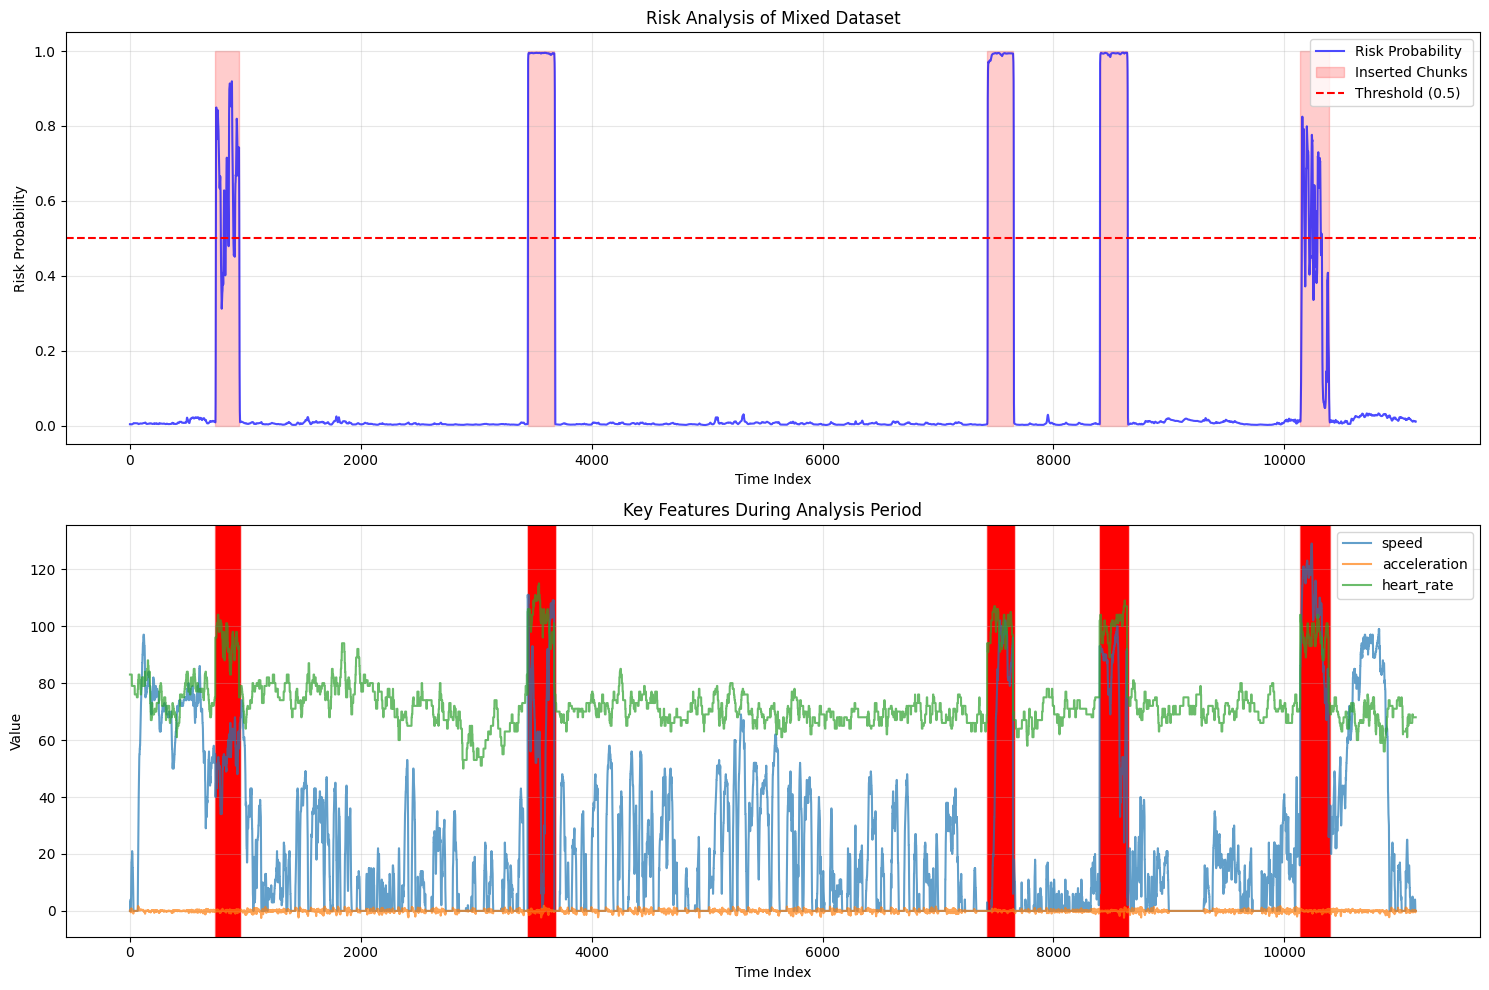


Risk Analysis Summary:

Overall Statistics:
Average Risk Probability: 0.091
Max Risk Probability: 0.996

Comparison of Normal vs Inserted Chunks:
Normal Segments - Average Risk: 0.009
Inserted Chunks - Average Risk: 0.807

High Risk Periods (Risk > 0.7):

Period 1:
Indices: 756 to 782
Average Risk: 0.793
From inserted chunk: Yes

Period 2:
Indices: 848 to 850
Average Risk: 0.712
From inserted chunk: Yes

Period 3:
Indices: 868 to 900
Average Risk: 0.865
From inserted chunk: Yes

Period 4:
Indices: 931 to 942
Average Risk: 0.774
From inserted chunk: Yes

Period 5:
Indices: 951 to 955
Average Risk: 0.738
From inserted chunk: Yes

Period 6:
Indices: 3458 to 3691
Average Risk: 0.993
From inserted chunk: Yes

Period 7:
Indices: 7441 to 7666
Average Risk: 0.988
From inserted chunk: Yes

Period 8:
Indices: 8413 to 8653
Average Risk: 0.992
From inserted chunk: Yes

Period 9:
Indices: 10164 to 10170
Average Risk: 0.780
From inserted chunk: Yes

Period 10:
Indices: 10172 to 10178
Average Risk: 

/var/folders/gc/j85pjfkj2hj91x1mhg6zb6f80000gn/T/ipykernel_56529/1433330399.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk_periods['group'] = (high_risk_periods.index.to_series().diff() > 1).cumsum()


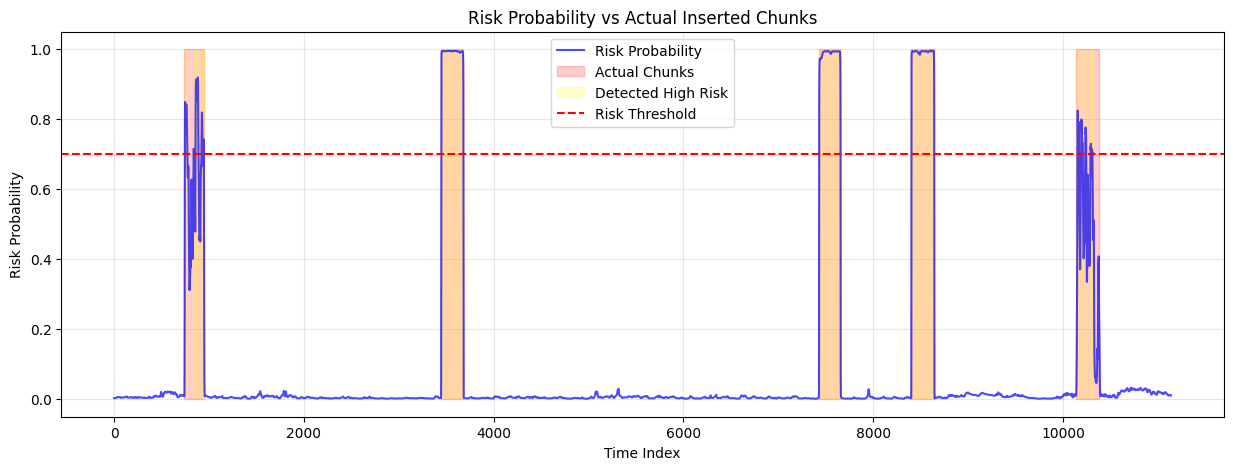

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_mixed_dataset(mixed_df, model, scaler, sequence_length, feature_columns):
    """
    Analyze the mixed dataset and calculate risk levels
    """
    try:
        # Prepare features
        X = mixed_df[feature_columns].values
        X_scaled = scaler.transform(X)
        
        # Create sequences
        sequences = []
        for i in range(len(X_scaled) - sequence_length):
            sequences.append(X_scaled[i:i + sequence_length])
        X_seq = np.array(sequences)
        
        # Get risk predictions
        risk_probs = model.predict(X_seq)
        
        # Add predictions to dataframe
        results_df = mixed_df.iloc[sequence_length:].copy()
        results_df['risk_probability'] = risk_probs
        
        # Plot results
        plt.figure(figsize=(15, 10))
        
        # Risk probability plot
        plt.subplot(2, 1, 1)
        plt.plot(range(len(results_df)), results_df['risk_probability'], 
                'b-', label='Risk Probability', alpha=0.7)
        
        # Highlight chunks
        chunk_mask = results_df['data_source'] == 'abnormal'
        plt.fill_between(range(len(results_df)), 0, 1, 
                        where=chunk_mask,
                        color='red', alpha=0.2, label='Inserted Chunks')
        
        plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
        plt.title('Risk Analysis of Mixed Dataset')
        plt.xlabel('Time Index')
        plt.ylabel('Risk Probability')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Key features plot
        plt.subplot(2, 1, 2)
        key_features = ['speed', 'acceleration', 'heart_rate']
        for feature in key_features:
            normalized_values = results_df[feature].values
            plt.plot(range(len(results_df)), normalized_values,
                    label=feature, alpha=0.7)
        
        # Highlight chunks in features plot
        y_min = min(results_df[key_features].min())
        y_max = max(results_df[key_features].max())
        chunk_indices = results_df[chunk_mask].index
        for start_idx in chunk_indices:
            plt.axvspan(start_idx - sequence_length, start_idx, 
                       color='red', alpha=0.2)
        
        plt.title('Key Features During Analysis Period')
        plt.xlabel('Time Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate statistics
        print("\nRisk Analysis Summary:")
        print("\nOverall Statistics:")
        print(f"Average Risk Probability: {results_df['risk_probability'].mean():.3f}")
        print(f"Max Risk Probability: {results_df['risk_probability'].max():.3f}")
        
        print("\nComparison of Normal vs Inserted Chunks:")
        normal_risk = results_df[results_df['data_source'] == 'normal']['risk_probability']
        abnormal_risk = results_df[results_df['data_source'] == 'abnormal']['risk_probability']
        
        print(f"Normal Segments - Average Risk: {normal_risk.mean():.3f}")
        print(f"Inserted Chunks - Average Risk: {abnormal_risk.mean():.3f}")
        
        # Find high-risk periods
        high_risk_threshold = 0.7
        high_risk_periods = results_df[results_df['risk_probability'] > high_risk_threshold]
        
        print(f"\nHigh Risk Periods (Risk > {high_risk_threshold}):")
        if len(high_risk_periods) > 0:
            # Group consecutive high-risk periods
            high_risk_periods['group'] = (high_risk_periods.index.to_series().diff() > 1).cumsum()
            for group, period in high_risk_periods.groupby('group'):
                print(f"\nPeriod {group + 1}:")
                print(f"Indices: {period.index[0]} to {period.index[-1]}")
                print(f"Average Risk: {period['risk_probability'].mean():.3f}")
                print(f"From inserted chunk: {'Yes' if any(period['data_source'] == 'abnormal') else 'No'}")
        else:
            print("No high-risk periods detected")
        
        # Add a column indicating high risk periods
        results_df['high_risk'] = results_df['risk_probability'] > high_risk_threshold
        
        return results_df
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

# Read the mixed dataset
mixed_df = pd.read_csv('mixed_dataset.csv')

# Define feature columns
feature_columns = ['speed', 'rpm', 'acceleration', 'throttle_position', 
                  'engine_temperature', 'engine_load_value', 'heart_rate',
                  'precipitation', 'accidents_onsite', 'design_speed',
                  'current_weather', 'visibility']

# Analyze the dataset
results_df = analyze_mixed_dataset(mixed_df, model, scaler, sequence_length, feature_columns)

# Save results
results_df.to_csv('analysis_results.csv', index=False)

# Additional visualization of risk vs actual chunks
plt.figure(figsize=(15, 5))
plt.plot(range(len(results_df)), results_df['risk_probability'], 'b-', label='Risk Probability', alpha=0.7)
plt.fill_between(range(len(results_df)), 0, 1,
                where=results_df['data_source'] == 'abnormal',
                color='red', alpha=0.2, label='Actual Chunks')
plt.fill_between(range(len(results_df)), 0, 1,
                where=results_df['high_risk'],
                color='yellow', alpha=0.2, label='Detected High Risk')
plt.axhline(y=0.7, color='r', linestyle='--', label='Risk Threshold')
plt.title('Risk Probability vs Actual Inserted Chunks')
plt.xlabel('Time Index')
plt.ylabel('Risk Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bayesian_changepoint_detection.bayesian_changepoint_detection import offline_changepoint_detection
from bayesian_changepoint_detection.hazard_functions import constant_hazard
from functools import partial
import scipy.stats as stats

def detect_and_visualize_changes(results_df, hazard_window=50):
    """
    Perform Bayesian changepoint detection and visualize results with inserted chunks
    """
    # Prepare the data
    risk_data = results_df['risk_probability'].values
    
    # Perform Bayesian changepoint detection
    Q, P, Pcp = offline_changepoint_detection(
        risk_data,
        partial(const_prior, l=(len(risk_data)+1)),
        stats.norm,
        truncate=-50
    )
    
    # Find the most probable changepoints
    max_P = np.argmax(P, axis=0)
    changepoints = np.where(P.max(axis=0) > 0.5)[0]
    
    # Create visualization
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Risk probability and inserted chunks
    plt.subplot(2, 1, 1)
    
    # Plot risk probability
    plt.plot(range(len(results_df)), results_df['risk_probability'], 
             'b-', label='Risk Probability', alpha=0.7)
    
    # Highlight inserted chunks
    chunk_mask = results_df['data_source'] == 'abnormal'
    plt.fill_between(range(len(results_df)), 0, 1,
                    where=chunk_mask,
                    color='red', alpha=0.2, label='Inserted Chunks')
    
    # Mark changepoints
    for cp in changepoints:
        plt.axvline(x=cp, color='g', linestyle='--', alpha=0.5)
        plt.text(cp, 1.1, f'Change at {cp}', rotation=45, ha='right')
    
    plt.title('Risk Probability with Bayesian Changepoints')
    plt.xlabel('Time Index')
    plt.ylabel('Risk Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Probability of changepoint
    plt.subplot(2, 1, 2)
    plt.imshow(np.flipud(P), cmap='viridis', aspect='auto')
    plt.title('Probability of Changepoint')
    plt.xlabel('Time Index')
    plt.ylabel('Model Order')
    plt.colorbar(label='Probability')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis of changepoints vs chunks
    chunk_locations = results_df[results_df['data_source'] == 'abnormal'].index
    chunk_groups = np.split(chunk_locations, np.where(np.diff(chunk_locations) != 1)[0] + 1)
    
    print("\nChangepoint Analysis:")
    print(f"Number of detected changepoints: {len(changepoints)}")
    
    print("\nComparison with inserted chunks:")
    for i, chunk in enumerate(chunk_groups, 1):
        chunk_start = chunk[0]
        chunk_end = chunk[-1]
        
        # Find changepoints near chunk boundaries
        nearby_changes_start = [cp for cp in changepoints if abs(cp - chunk_start) < hazard_window]
        nearby_changes_end = [cp for cp in changepoints if abs(cp - chunk_end) < hazard_window]
        
        print(f"\nChunk {i} (Rows {chunk_start} to {chunk_end}):")
        print(f"Nearby changepoints at start: {nearby_changes_start}")
        print(f"Nearby changepoints at end: {nearby_changes_end}")
    
    return changepoints, P

# Read the results
results_df = pd.read_csv('analysis_results.csv')

# Detect and visualize changepoints
changepoints, probability_matrix = detect_and_visualize_changes(results_df)

# Create a combined visualization
plt.figure(figsize=(20, 8))

# Plot risk probability
plt.plot(range(len(results_df)), results_df['risk_probability'], 
         'b-', label='Risk Probability', alpha=0.7)

# Highlight inserted chunks
chunk_mask = results_df['data_source'] == 'abnormal'
plt.fill_between(range(len(results_df)), 0, 1,
                where=chunk_mask,
                color='red', alpha=0.2, label='Inserted Chunks')

# Mark changepoints with vertical lines and probability
for cp in changepoints:
    prob = probability_matrix.max(axis=0)[cp]
    plt.axvline(x=cp, color='g', linestyle='--', alpha=0.5)
    plt.text(cp, 1.1, f'Change\nP={prob:.2f}', 
             rotation=45, ha='right')

plt.title('Risk Probability with Bayesian Changepoints and Inserted Chunks')
plt.xlabel('Time Index')
plt.ylabel('Risk Probability')
plt.legend()
plt.grid(True, alpha=0.3)

# Add probability colorbar
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([])
plt.colorbar(sm, label='Changepoint Probability')

plt.tight_layout()
plt.show()

# Calculate detection accuracy
def analyze_changepoint_accuracy(results_df, changepoints, window_size=50):
    """Analyze how well changepoints align with actual transitions"""
    
    # Find actual transition points
    chunk_mask = results_df['data_source'] == 'abnormal'
    transitions = np.where(np.diff(chunk_mask.astype(int)) != 0)[0]
    
    # Count correct detections
    correct_detections = 0
    missed_transitions = 0
    false_positives = 0
    
    # Check each transition
    for trans in transitions:
        nearby_changes = [cp for cp in changepoints if abs(cp - trans) < window_size]
        if nearby_changes:
            correct_detections += 1
        else:
            missed_transitions += 1
    
    # Check for false positives
    for cp in changepoints:
        nearby_trans = [t for t in transitions if abs(t - cp) < window_size]
        if not nearby_trans:
            false_positives += 1
    
    print("\nChangepoint Detection Accuracy:")
    print(f"Correct Detections: {correct_detections}")
    print(f"Missed Transitions: {missed_transitions}")
    print(f"False Positives: {false_positives}")
    print(f"Detection Rate: {correct_detections / len(transitions):.2%}")
    
    return {
        'correct_detections': correct_detections,
        'missed_transitions': missed_transitions,
        'false_positives': false_positives,
        'detection_rate': correct_detections / len(transitions)
    }

# Analyze accuracy of changepoint detection
accuracy_metrics = analyze_changepoint_accuracy(results_df, changepoints)

ModuleNotFoundError: No module named 'bayesian_changepoint_detection'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(



Changepoint Analysis:
Number of detected changepoints: 10

Comparison with inserted chunks:

Chunk 1 (Rows 740 to 944):
Nearby changepoints at start: [740]
Nearby changepoints at end: [950]

Chunk 2 (Rows 3445 to 3675):
Nearby changepoints at start: [3445, 3450]
Nearby changepoints at end: [3685]

Chunk 3 (Rows 7426 to 7649):
Nearby changepoints at start: [7430]
Nearby changepoints at end: [7655]

Chunk 4 (Rows 8400 to 8637):
Nearby changepoints at start: [8400]
Nearby changepoints at end: []

Chunk 5 (Rows 10138 to 10383):
Nearby changepoints at start: []
Nearby changepoints at end: [10390]


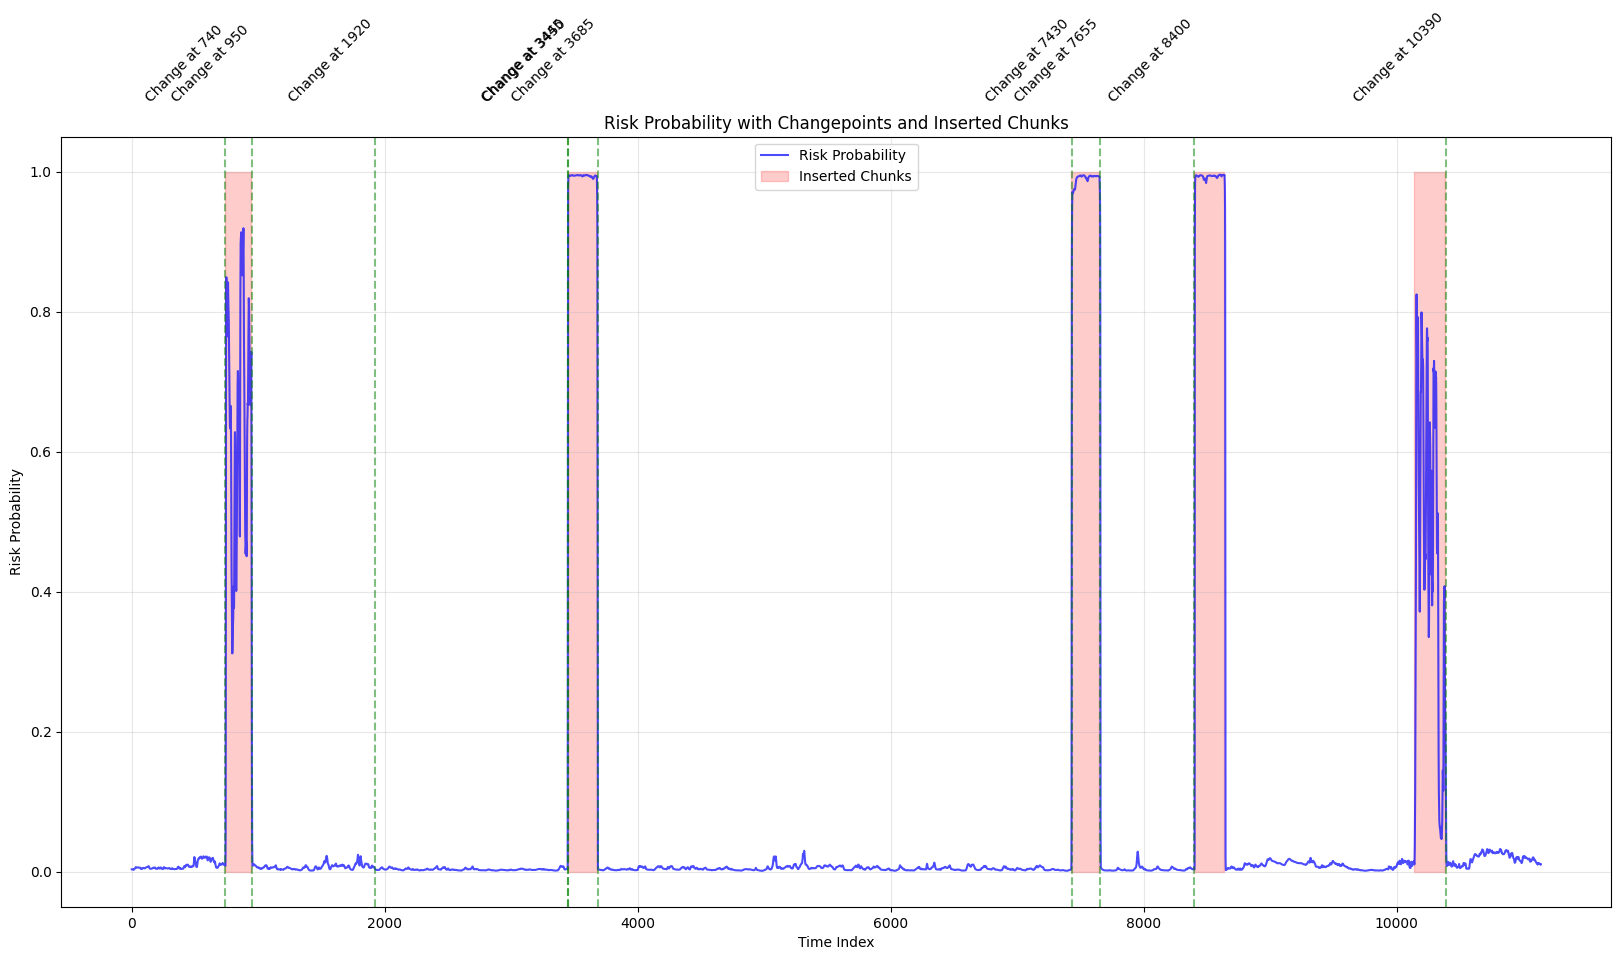


Segment Analysis:
    start    end  mean_risk  std_risk  abnormal_ratio
0       0    740   0.008682  0.005591        0.000000
1     740    950   0.634076  0.184803        0.976190
2     950   1920   0.007081  0.006396        0.000000
3    1920   3445   0.003310  0.001312        0.000000
4    3445   3450   0.453578  0.478506        1.000000
5    3450   3685   0.983925  0.087720        0.961702
6    3685   7430   0.004707  0.003682        0.001068
7    7430   7655   0.987406  0.028188        0.977778
8    7655   8400   0.006399  0.045572        0.000000
9    8400  10390   0.185197  0.345396        0.243216
10  10390  11139   0.018903  0.007945        0.000000


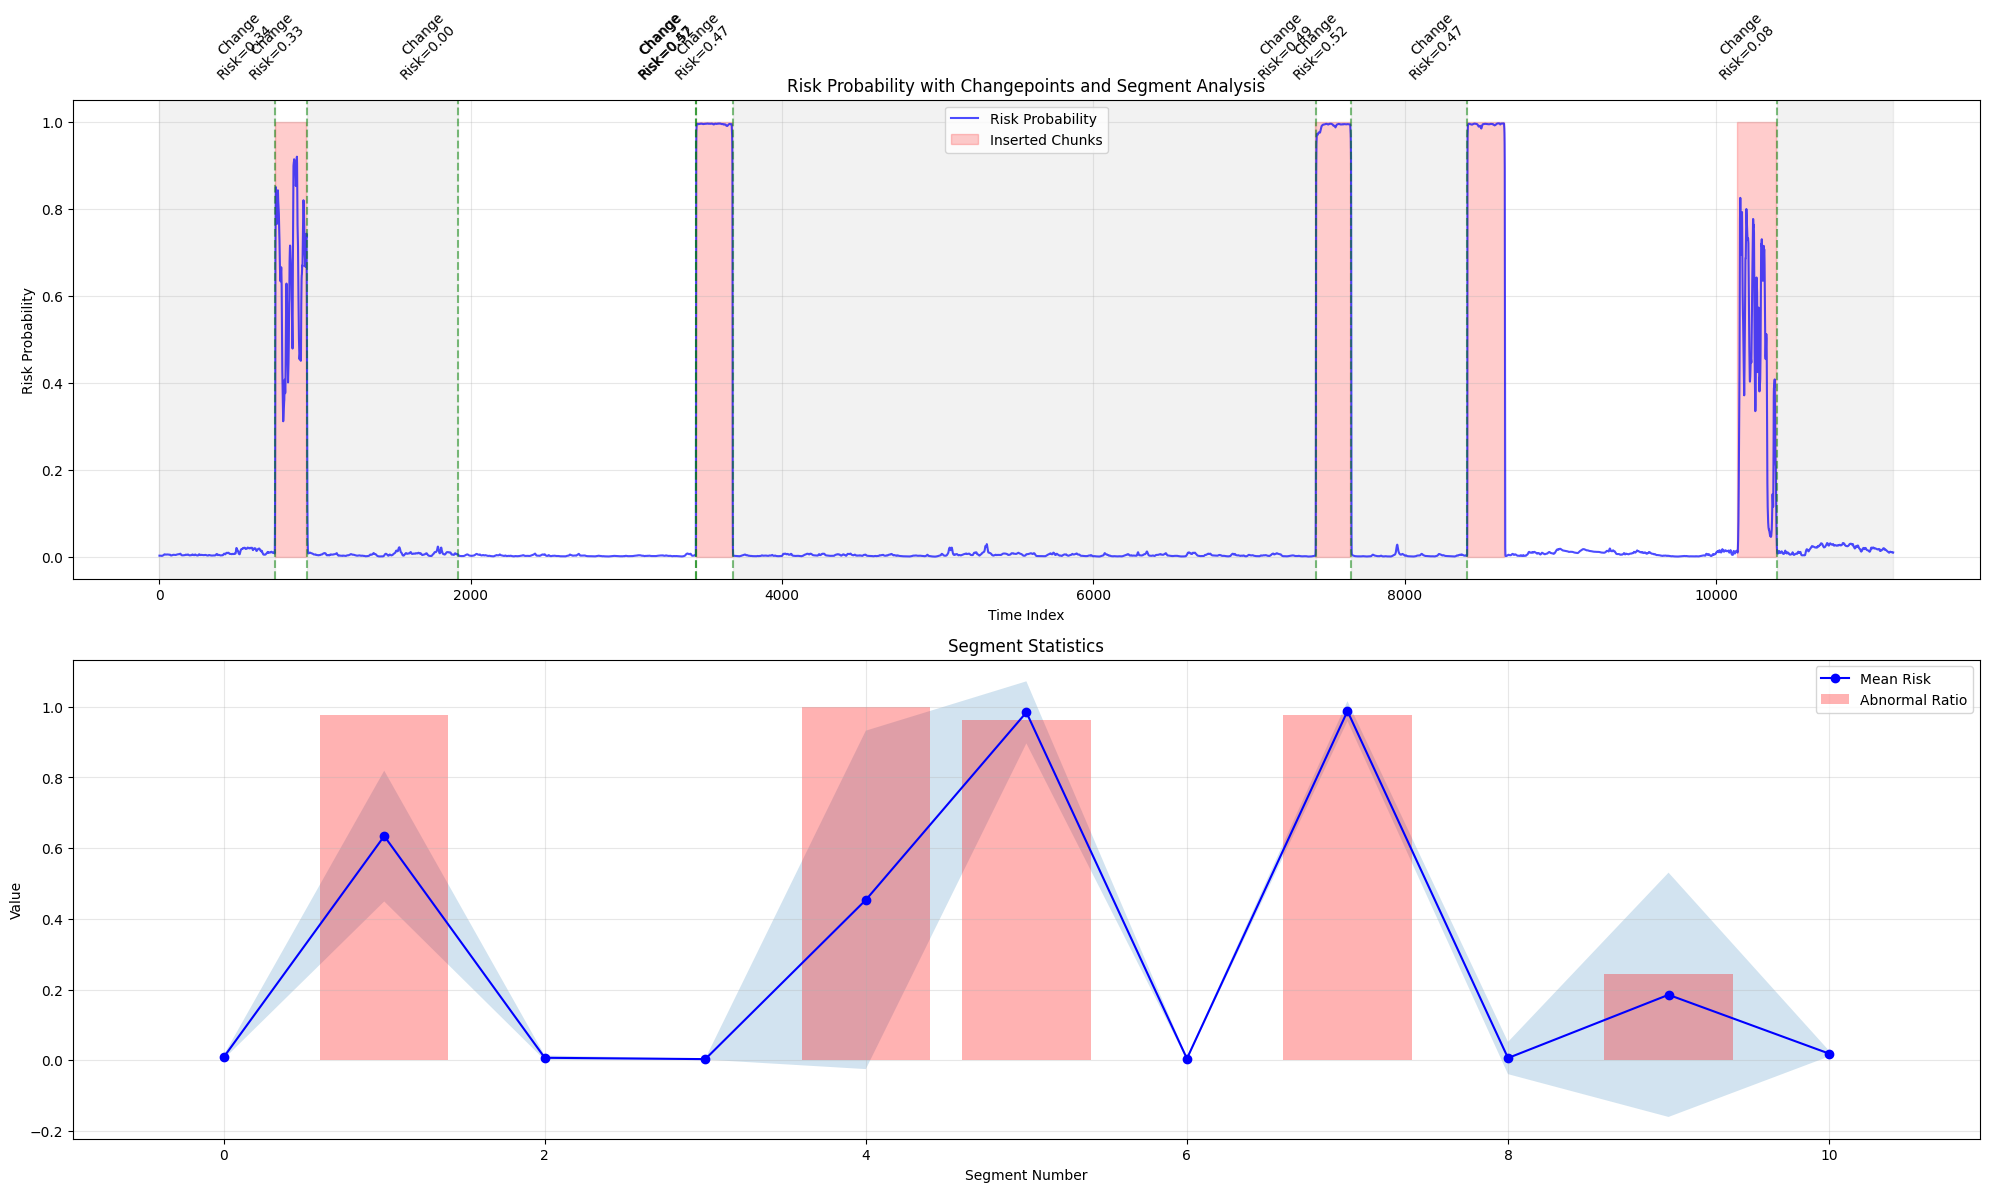

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import seaborn as sns

def detect_and_visualize_changes(results_df, n_bkps=10):
    """
    Perform changepoint detection and visualize results with inserted chunks
    """
    # Prepare the data
    risk_data = results_df['risk_probability'].values.reshape(-1, 1)
    
    # Perform changepoint detection
    algo = rpt.Binseg(model="normal").fit(risk_data)
    changepoints = algo.predict(n_bkps=n_bkps)
    
    # Create visualization
    plt.figure(figsize=(20, 10))
    
    # Plot risk probability
    plt.plot(range(len(results_df)), results_df['risk_probability'], 
             'b-', label='Risk Probability', alpha=0.7)
    
    # Highlight inserted chunks
    chunk_mask = results_df['data_source'] == 'abnormal'
    plt.fill_between(range(len(results_df)), 0, 1,
                    where=chunk_mask,
                    color='red', alpha=0.2, label='Inserted Chunks')
    
    # Mark changepoints
    for cp in changepoints[:-1]:  # Exclude the last point which is the series length
        plt.axvline(x=cp, color='g', linestyle='--', alpha=0.5)
        plt.text(cp, 1.1, f'Change at {cp}', rotation=45, ha='right')
    
    plt.title('Risk Probability with Changepoints and Inserted Chunks')
    plt.xlabel('Time Index')
    plt.ylabel('Risk Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Print analysis
    print("\nChangepoint Analysis:")
    print(f"Number of detected changepoints: {len(changepoints)-1}")  # -1 to exclude series length
    
    # Analyze alignment with chunks
    chunk_locations = results_df[results_df['data_source'] == 'abnormal'].index
    chunk_groups = np.split(chunk_locations, np.where(np.diff(chunk_locations) != 1)[0] + 1)
    
    print("\nComparison with inserted chunks:")
    window_size = 50  # Window size for considering a changepoint as "near" a chunk boundary
    
    for i, chunk in enumerate(chunk_groups, 1):
        chunk_start = chunk[0]
        chunk_end = chunk[-1]
        
        # Find changepoints near chunk boundaries
        nearby_changes_start = [cp for cp in changepoints[:-1] 
                              if abs(cp - chunk_start) < window_size]
        nearby_changes_end = [cp for cp in changepoints[:-1] 
                            if abs(cp - chunk_end) < window_size]
        
        print(f"\nChunk {i} (Rows {chunk_start} to {chunk_end}):")
        print(f"Nearby changepoints at start: {nearby_changes_start}")
        print(f"Nearby changepoints at end: {nearby_changes_end}")
    
    plt.show()
    
    # Calculate segment statistics
    segments = []
    start = 0
    for end in changepoints[:-1]:
        segment_data = results_df.iloc[start:end]
        segment_info = {
            'start': start,
            'end': end,
            'mean_risk': segment_data['risk_probability'].mean(),
            'std_risk': segment_data['risk_probability'].std(),
            'abnormal_ratio': (segment_data['data_source'] == 'abnormal').mean()
        }
        segments.append(segment_info)
        start = end
    
    # Last segment
    segment_data = results_df.iloc[start:]
    segments.append({
        'start': start,
        'end': len(results_df),
        'mean_risk': segment_data['risk_probability'].mean(),
        'std_risk': segment_data['risk_probability'].std(),
        'abnormal_ratio': (segment_data['data_source'] == 'abnormal').mean()
    })
    
    return pd.DataFrame(segments), changepoints

# Read the results
results_df = pd.read_csv('analysis_results.csv')

# Detect and visualize changepoints
segments_df, changepoints = detect_and_visualize_changes(results_df)

# Print segment analysis
print("\nSegment Analysis:")
print(segments_df)

# Create a detailed visualization
plt.figure(figsize=(20, 12))

# Plot 1: Risk probability with changepoints and segments
plt.subplot(2, 1, 1)
plt.plot(range(len(results_df)), results_df['risk_probability'], 
         'b-', label='Risk Probability', alpha=0.7)

# Color segments alternately
for i, (start, end) in enumerate(zip([0] + changepoints[:-1], changepoints)):
    plt.axvspan(start, end, 
                color='gray' if i % 2 == 0 else 'white', 
                alpha=0.1)

# Highlight inserted chunks
chunk_mask = results_df['data_source'] == 'abnormal'
plt.fill_between(range(len(results_df)), 0, 1,
                where=chunk_mask,
                color='red', alpha=0.2, label='Inserted Chunks')

# Mark changepoints
for cp in changepoints[:-1]:
    plt.axvline(x=cp, color='g', linestyle='--', alpha=0.5)
    mean_risk = results_df.iloc[cp-50:cp+50]['risk_probability'].mean()
    plt.text(cp, 1.1, f'Change\nRisk={mean_risk:.2f}', 
             rotation=45, ha='right')

plt.title('Risk Probability with Changepoints and Segment Analysis')
plt.xlabel('Time Index')
plt.ylabel('Risk Probability')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Segment statistics
plt.subplot(2, 1, 2)
plt.plot(range(len(segments_df)), segments_df['mean_risk'], 'b-o', label='Mean Risk')
plt.fill_between(range(len(segments_df)), 
                segments_df['mean_risk'] - segments_df['std_risk'],
                segments_df['mean_risk'] + segments_df['std_risk'],
                alpha=0.2)
plt.bar(range(len(segments_df)), segments_df['abnormal_ratio'], 
        alpha=0.3, color='red', label='Abnormal Ratio')

plt.title('Segment Statistics')
plt.xlabel('Segment Number')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


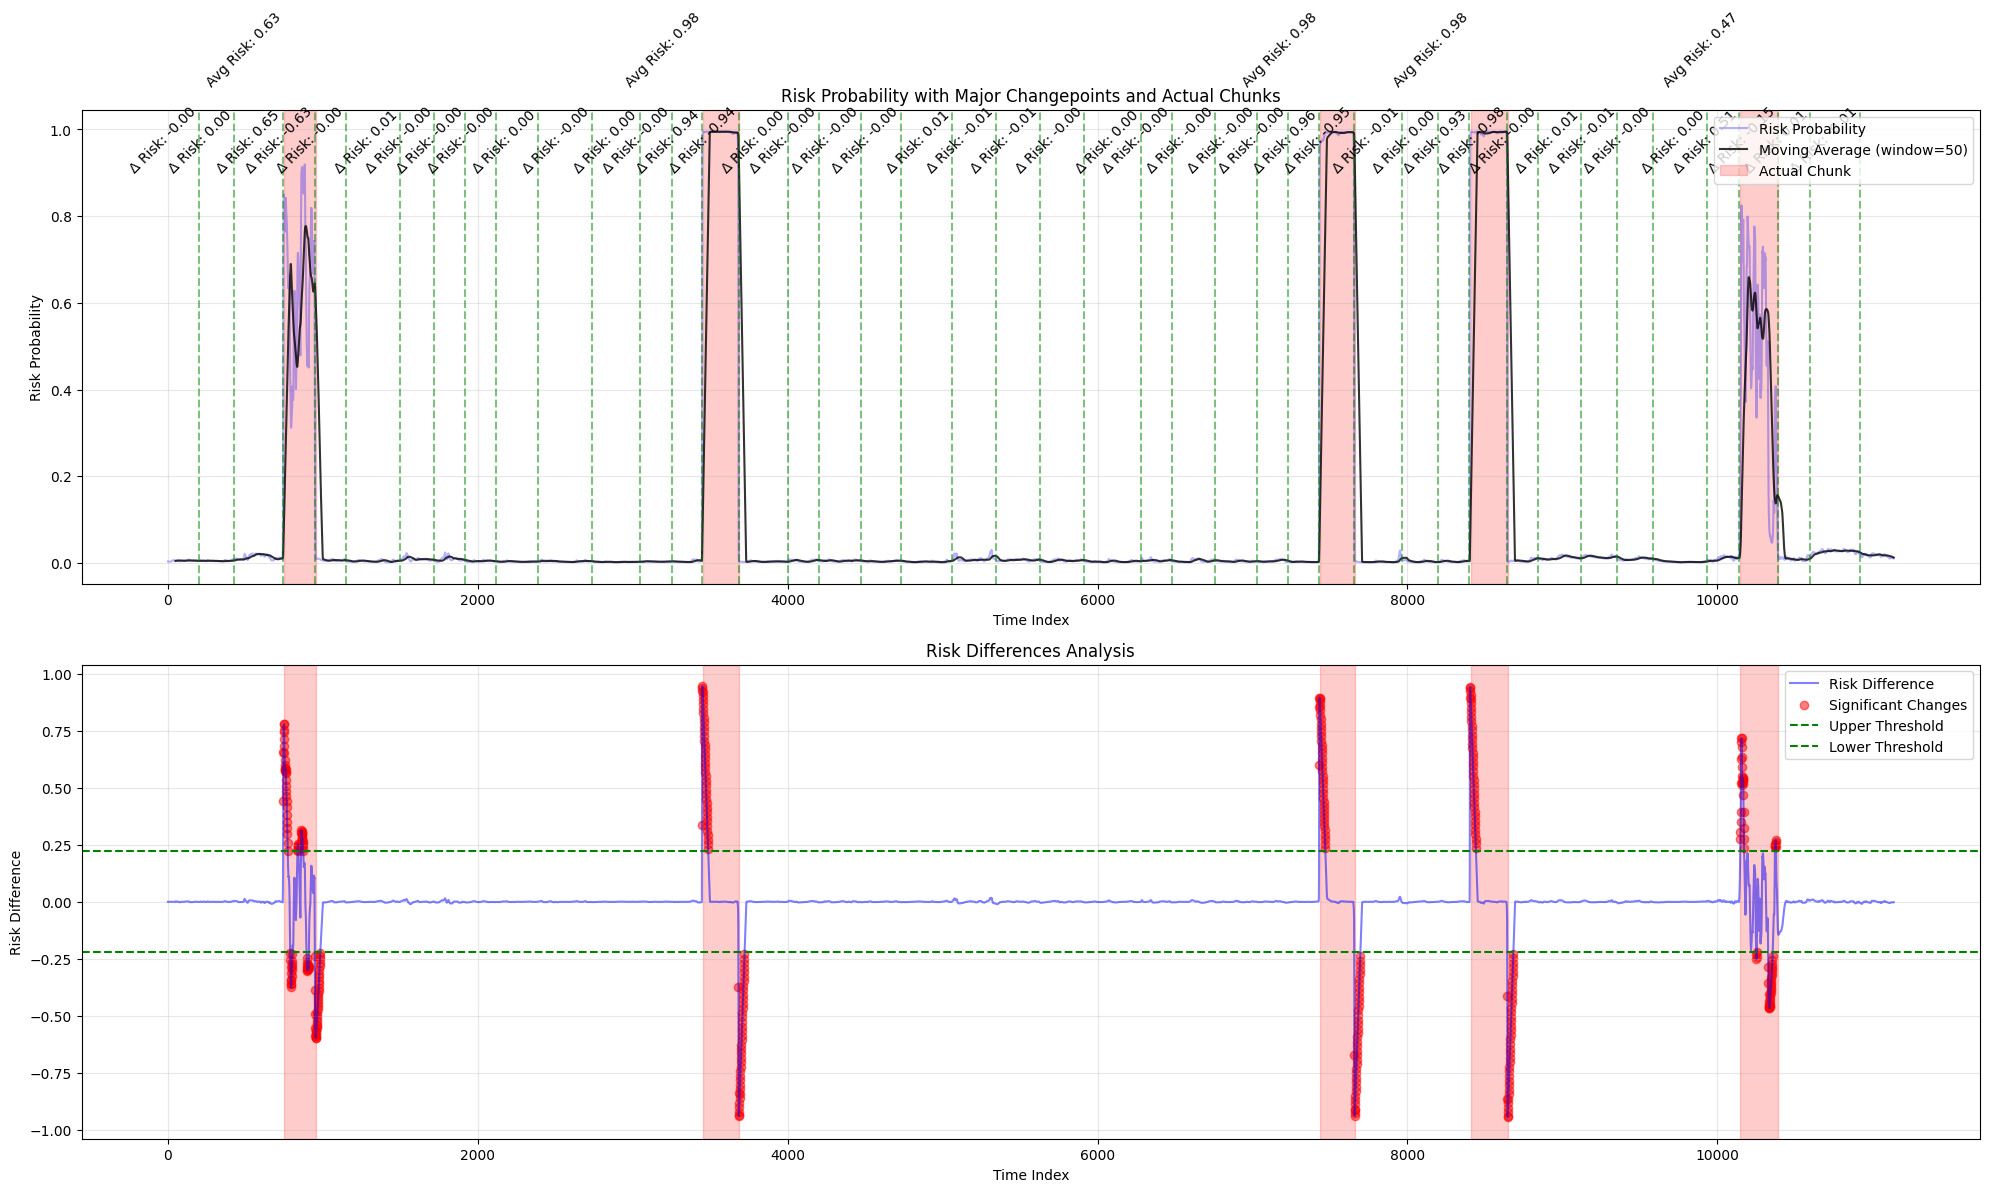


Chunk Analysis:

Chunk 1 (Positions 750 to 955):
Average risk within chunk: 0.628
Average risk before chunk: 0.103
Average risk after chunk: 0.008
Maximum risk in chunk: 0.919
Risk variance in chunk: 0.036

Chunk 2 (Positions 3455 to 3686):
Average risk within chunk: 0.980
Average risk before chunk: 0.148
Average risk after chunk: 0.003
Maximum risk in chunk: 0.995
Risk variance in chunk: 0.012

Chunk 3 (Positions 7436 to 7660):
Average risk within chunk: 0.978
Average risk before chunk: 0.111
Average risk after chunk: 0.003
Maximum risk in chunk: 0.995
Risk variance in chunk: 0.010

Chunk 4 (Positions 8410 to 8648):
Average risk within chunk: 0.979
Average risk before chunk: 0.143
Average risk after chunk: 0.005
Maximum risk in chunk: 0.996
Risk variance in chunk: 0.012

Chunk 5 (Positions 10148 to 10394):
Average risk within chunk: 0.468
Average risk before chunk: 0.023
Average risk after chunk: 0.010
Maximum risk in chunk: 0.825
Risk variance in chunk: 0.057


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import seaborn as sns

def detect_and_visualize_changes(results_df, min_size=200):
    """
    Perform changepoint detection focusing on major changes
    """
    # Prepare the data
    risk_data = results_df['risk_probability'].values.reshape(-1, 1)
    
    # Use Binary Segmentation with larger minimum segment size
    algo = rpt.Binseg(model="normal", min_size=min_size).fit(risk_data)
    changepoints = algo.predict(pen=0.5)  # Higher penalty for fewer changepoints
    
    # Get actual chunk positions from the data
    actual_chunks = [
        {'start': 750, 'end': 750+205},
        {'start': 3455, 'end': 3455+231},
        {'start': 7436, 'end': 7436+224},
        {'start': 8410, 'end': 8410+238},
        {'start': 10148, 'end': 10148+246}
    ]
    
    # Create main visualization
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Risk probability with chunks and changepoints
    plt.subplot(2, 1, 1)
    
    # Plot risk probability with moving average
    window_size = 50
    rolling_mean = pd.Series(risk_data.flatten()).rolling(window=window_size).mean()
    plt.plot(range(len(results_df)), results_df['risk_probability'], 
             'b-', label='Risk Probability', alpha=0.3)
    plt.plot(range(len(results_df)), rolling_mean, 
             'k-', label=f'Moving Average (window={window_size})', alpha=0.8)
    
    # Highlight actual chunks
    for chunk in actual_chunks:
        plt.axvspan(chunk['start'], chunk['end'], 
                   color='red', alpha=0.2, label='Actual Chunk' if chunk == actual_chunks[0] else "")
        
        # Calculate average risk in chunk
        chunk_risk = results_df['risk_probability'].iloc[chunk['start']:chunk['end']].mean()
        plt.text(chunk['start'], 1.1, f'Avg Risk: {chunk_risk:.2f}', 
                rotation=45, ha='right')
    
    # Mark detected changepoints
    for cp in changepoints[:-1]:
        plt.axvline(x=cp, color='g', linestyle='--', alpha=0.5)
        # Calculate risk difference around changepoint
        before_risk = results_df['risk_probability'].iloc[cp-50:cp].mean()
        after_risk = results_df['risk_probability'].iloc[cp:cp+50].mean()
        risk_diff = after_risk - before_risk
        plt.text(cp, 0.9, f'Δ Risk: {risk_diff:.2f}', rotation=45, ha='right')
    
    plt.title('Risk Probability with Major Changepoints and Actual Chunks')
    plt.xlabel('Time Index')
    plt.ylabel('Risk Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Risk difference analysis
    plt.subplot(2, 1, 2)
    
    # Calculate risk differences
    risk_diff = np.zeros(len(results_df))
    for i in range(window_size, len(results_df)):
        risk_diff[i] = (results_df['risk_probability'].iloc[i] - 
                       results_df['risk_probability'].iloc[i-window_size:i].mean())
    
    plt.plot(range(len(results_df)), risk_diff, 'b-', alpha=0.5, label='Risk Difference')
    
    # Highlight actual chunks
    for chunk in actual_chunks:
        plt.axvspan(chunk['start'], chunk['end'], 
                   color='red', alpha=0.2)
    
    # Mark significant changes
    threshold = np.std(risk_diff) * 2  # 2 standard deviations
    significant_changes = np.where(abs(risk_diff) > threshold)[0]
    plt.scatter(significant_changes, risk_diff[significant_changes], 
               color='red', alpha=0.5, label='Significant Changes')
    
    plt.axhline(y=threshold, color='g', linestyle='--', label='Upper Threshold')
    plt.axhline(y=-threshold, color='g', linestyle='--', label='Lower Threshold')
    
    plt.title('Risk Differences Analysis')
    plt.xlabel('Time Index')
    plt.ylabel('Risk Difference')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analysis of chunks and changes
    print("\nChunk Analysis:")
    for i, chunk in enumerate(actual_chunks, 1):
        chunk_data = results_df.iloc[chunk['start']:chunk['end']]
        before_chunk = results_df.iloc[max(0, chunk['start']-50):chunk['start']]
        after_chunk = results_df.iloc[chunk['end']:min(len(results_df), chunk['end']+50)]
        
        print(f"\nChunk {i} (Positions {chunk['start']} to {chunk['end']}):")
        print(f"Average risk within chunk: {chunk_data['risk_probability'].mean():.3f}")
        print(f"Average risk before chunk: {before_chunk['risk_probability'].mean():.3f}")
        print(f"Average risk after chunk: {after_chunk['risk_probability'].mean():.3f}")
        print(f"Maximum risk in chunk: {chunk_data['risk_probability'].max():.3f}")
        print(f"Risk variance in chunk: {chunk_data['risk_probability'].var():.3f}")
    
    return changepoints, risk_diff

# Read the results
results_df = pd.read_csv('analysis_results.csv')

# Detect and visualize changepoints
changepoints, risk_diff = detect_and_visualize_changes(results_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


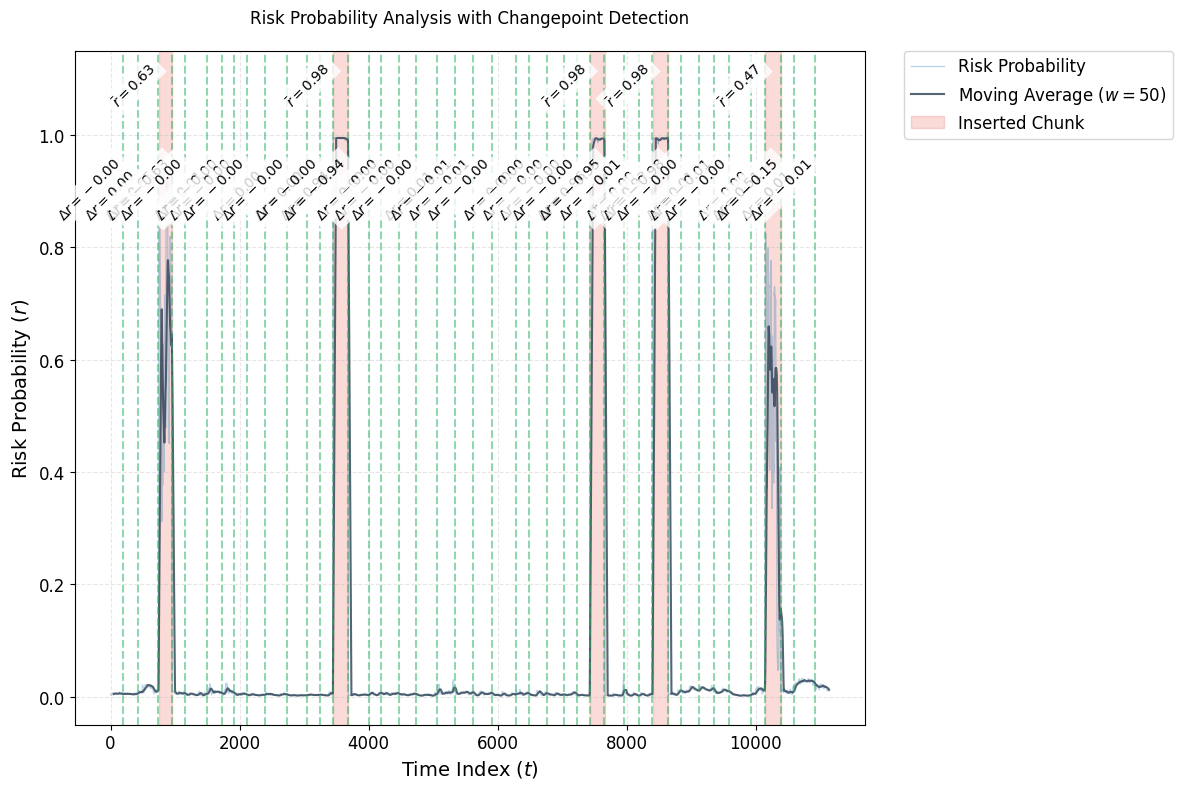


\begin{table}[h]
\caption{Chunk Analysis Results}
\begin{tabular}{cccccc}
\hline
Chunk & Position & Mean Risk & Before & After & Max Risk \\
\hline
1 & 750-955 & 0.628 & 0.103 & 0.008 & 0.919 \\
2 & 3455-3686 & 0.980 & 0.148 & 0.003 & 0.995 \\
3 & 7436-7660 & 0.978 & 0.111 & 0.003 & 0.995 \\
4 & 8410-8648 & 0.979 & 0.143 & 0.005 & 0.996 \\
5 & 10148-10394 & 0.468 & 0.023 & 0.010 & 0.825 \\
\hline
\end{tabular}
\end{table}


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import seaborn as sns
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Computer Modern Roman']
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['figure.titlesize'] = 16
matplotlib.rcParams['text.usetex'] = False

def detect_and_visualize_changes(results_df, min_size=200):
    """
    Perform changepoint detection with LaTeX formatted visualization
    """
    # Prepare the data
    risk_data = results_df['risk_probability'].values.reshape(-1, 1)
    
    # Use Binary Segmentation
    algo = rpt.Binseg(model="normal", min_size=min_size).fit(risk_data)
    changepoints = algo.predict(pen=0.5)
    
    # Get actual chunk positions
    actual_chunks = [
        {'start': 750, 'end': 750+205},
        {'start': 3455, 'end': 3455+231},
        {'start': 7436, 'end': 7436+224},
        {'start': 8410, 'end': 8410+238},
        {'start': 10148, 'end': 10148+246}
    ]
    
    # Create figure with LaTeX formatting
    plt.figure(figsize=(12, 8))
    
    # Calculate moving average
    window_size = 50
    rolling_mean = pd.Series(risk_data.flatten()).rolling(window=window_size).mean()
    
    # Plot risk probability
    plt.plot(range(len(results_df)), results_df['risk_probability'], 
             color='#1f77b4', alpha=0.3, label='Risk Probability',
             linewidth=1)
    
    # Plot moving average
    plt.plot(range(len(results_df)), rolling_mean, 
             color='#2c3e50', alpha=0.8, 
             label=f'Moving Average ($w={window_size}$)',
             linewidth=1.5)
    
    # Highlight actual chunks
    for chunk in actual_chunks:
        plt.axvspan(chunk['start'], chunk['end'], 
                   color='#e74c3c', alpha=0.2, 
                   label='Inserted Chunk' if chunk == actual_chunks[0] else "")
        
        # Calculate chunk statistics
        chunk_risk = results_df['risk_probability'].iloc[chunk['start']:chunk['end']].mean()
        plt.text(chunk['start'], 1.05, 
                f'$\\bar{{r}}={chunk_risk:.2f}$', 
                rotation=45, ha='right',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Mark changepoints
    for cp in changepoints[:-1]:
        plt.axvline(x=cp, color='#27ae60', linestyle='--', alpha=0.5)
        before_risk = results_df['risk_probability'].iloc[cp-50:cp].mean()
        after_risk = results_df['risk_probability'].iloc[cp:cp+50].mean()
        risk_diff = after_risk - before_risk
        plt.text(cp, 0.85, f'$\\Delta r={risk_diff:.2f}$', 
                rotation=45, ha='right',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Set title and labels
    plt.title('Risk Probability Analysis with Changepoint Detection', pad=20)
    plt.xlabel('Time Index ($t$)')
    plt.ylabel('Risk Probability ($r$)')
    
    # Customize grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Customize legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
              borderaxespad=0., frameon=True)
    
    # Set y-axis limits with padding
    plt.ylim(-0.05, 1.15)
    
    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    
    # Save high-quality figure
    plt.savefig('risk_analysis_latex.pdf', 
                bbox_inches='tight', 
                dpi=300,
                format='pdf')
    plt.show()
    
    # Print statistical analysis
    print("\n\\begin{table}[h]")
    print("\\caption{Chunk Analysis Results}")
    print("\\begin{tabular}{cccccc}")
    print("\\hline")
    print("Chunk & Position & Mean Risk & Before & After & Max Risk \\\\")
    print("\\hline")
    
    for i, chunk in enumerate(actual_chunks, 1):
        chunk_data = results_df.iloc[chunk['start']:chunk['end']]
        before_chunk = results_df.iloc[max(0, chunk['start']-50):chunk['start']]
        after_chunk = results_df.iloc[chunk['end']:min(len(results_df), chunk['end']+50)]
        
        print(f"{i} & {chunk['start']}-{chunk['end']} & "
              f"{chunk_data['risk_probability'].mean():.3f} & "
              f"{before_chunk['risk_probability'].mean():.3f} & "
              f"{after_chunk['risk_probability'].mean():.3f} & "
              f"{chunk_data['risk_probability'].max():.3f} \\\\")
    
    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")
    
    return changepoints

# Read the results
results_df = pd.read_csv('analysis_results.csv')

# Detect and visualize changepoints
changepoints = detect_and_visualize_changes(results_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


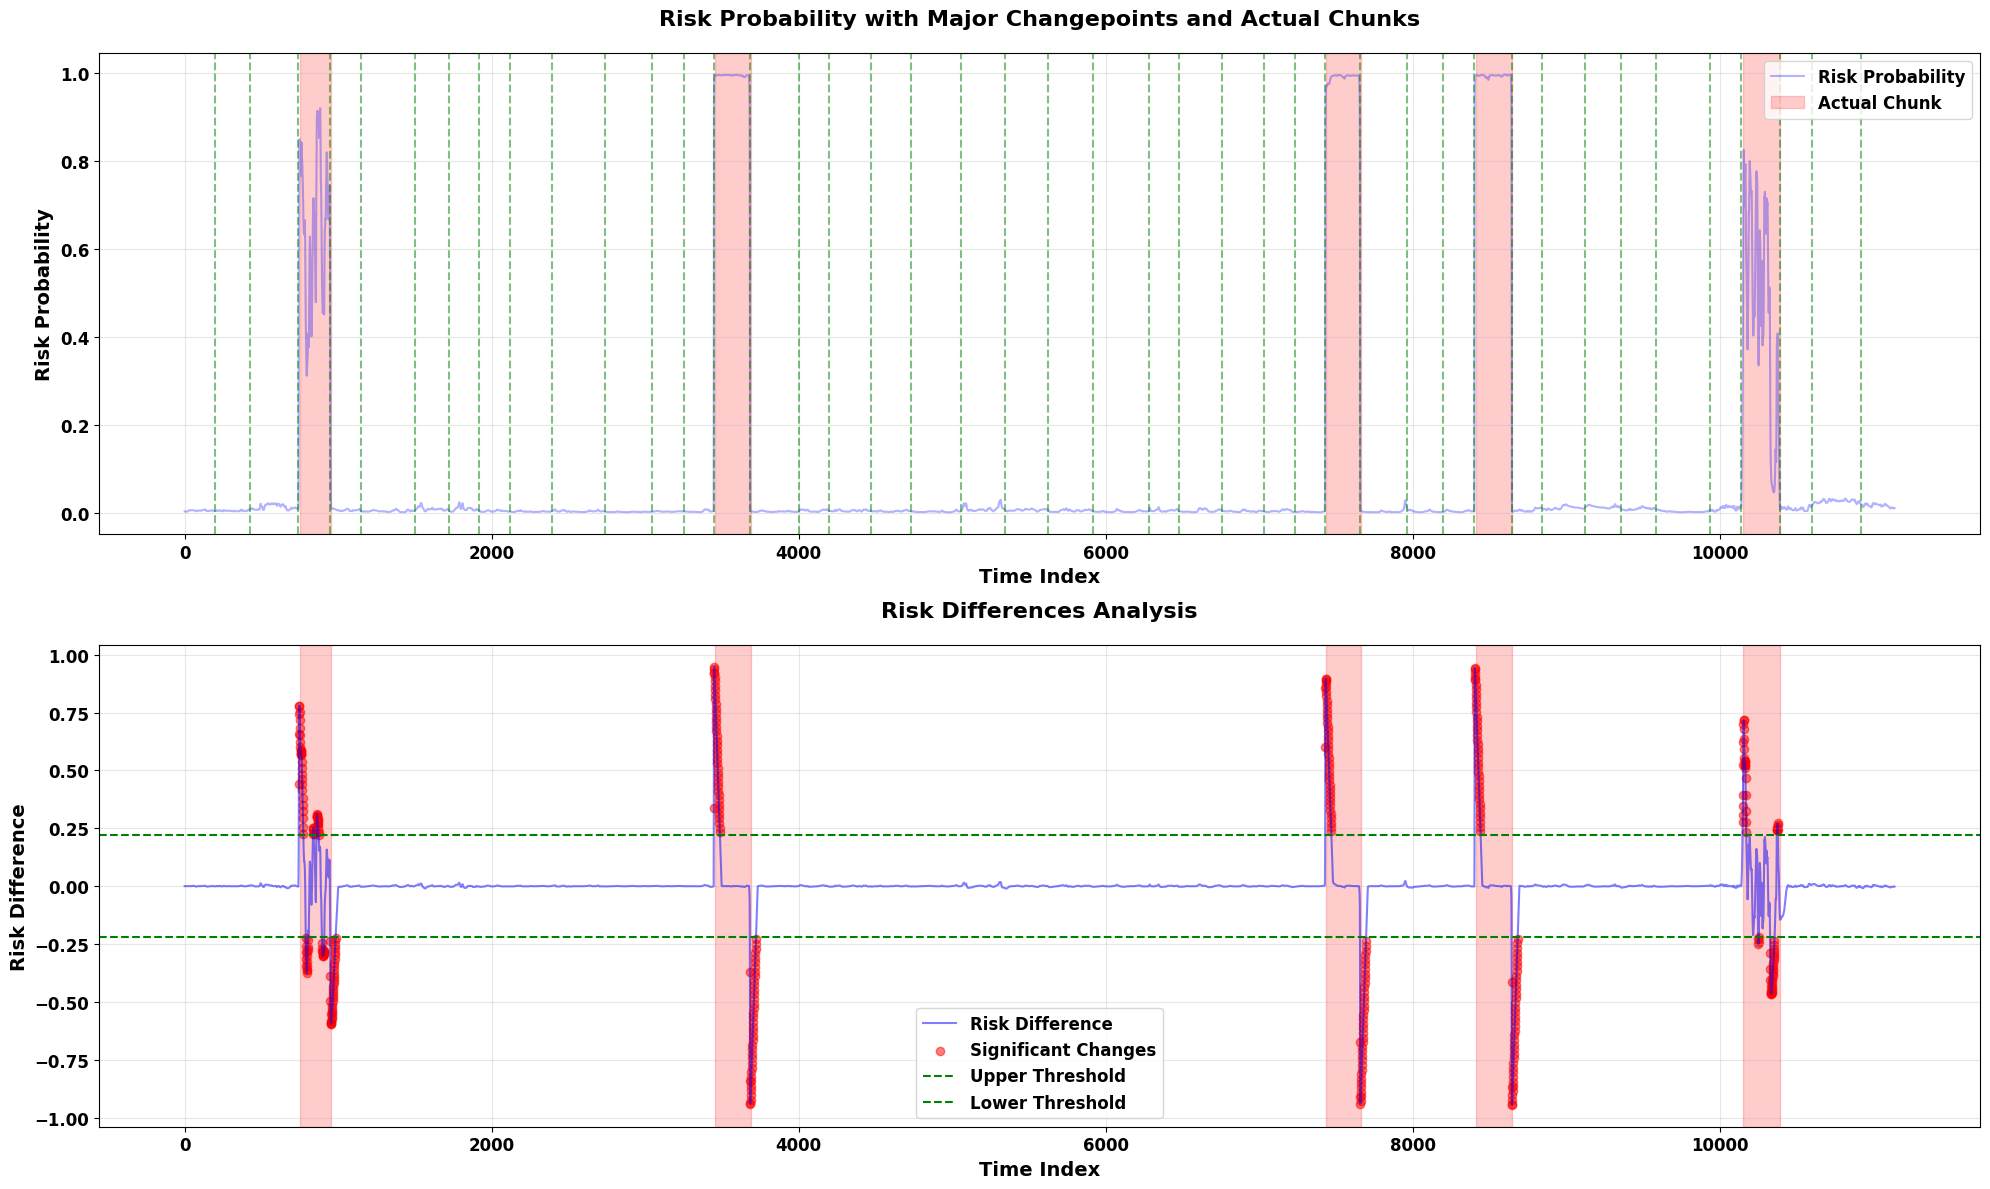


Chunk Analysis:

Chunk 1 (Positions 750 to 955):
Average risk within chunk: 0.628
Average risk before chunk: 0.103
Average risk after chunk: 0.008
Maximum risk in chunk: 0.919
Risk variance in chunk: 0.036

Chunk 2 (Positions 3455 to 3686):
Average risk within chunk: 0.980
Average risk before chunk: 0.148
Average risk after chunk: 0.003
Maximum risk in chunk: 0.995
Risk variance in chunk: 0.012

Chunk 3 (Positions 7436 to 7660):
Average risk within chunk: 0.978
Average risk before chunk: 0.111
Average risk after chunk: 0.003
Maximum risk in chunk: 0.995
Risk variance in chunk: 0.010

Chunk 4 (Positions 8410 to 8648):
Average risk within chunk: 0.979
Average risk before chunk: 0.143
Average risk after chunk: 0.005
Maximum risk in chunk: 0.996
Risk variance in chunk: 0.012

Chunk 5 (Positions 10148 to 10394):
Average risk within chunk: 0.468
Average risk before chunk: 0.023
Average risk after chunk: 0.010
Maximum risk in chunk: 0.825
Risk variance in chunk: 0.057


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import seaborn as sns

def detect_and_visualize_changes(results_df, min_size=200):
    """
    Perform changepoint detection focusing on major changes
    """
    # Set font parameters
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    
    # Prepare the data
    risk_data = results_df['risk_probability'].values.reshape(-1, 1)
    
    # Use Binary Segmentation with larger minimum segment size
    algo = rpt.Binseg(model="normal", min_size=min_size).fit(risk_data)
    changepoints = algo.predict(pen=0.5)  # Higher penalty for fewer changepoints
    
    # Get actual chunk positions from the data
    actual_chunks = [
        {'start': 750, 'end': 750+205},
        {'start': 3455, 'end': 3455+231},
        {'start': 7436, 'end': 7436+224},
        {'start': 8410, 'end': 8410+238},
        {'start': 10148, 'end': 10148+246}
    ]
    
    # Create main visualization
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Risk probability with chunks and changepoints
    plt.subplot(2, 1, 1)
    
    # Plot risk probability with moving average
    window_size = 50
    rolling_mean = pd.Series(risk_data.flatten()).rolling(window=window_size).mean()
    plt.plot(range(len(results_df)), results_df['risk_probability'], 
             'b-', label='Risk Probability', alpha=0.3)

    
    # Highlight actual chunks
    for chunk in actual_chunks:
        plt.axvspan(chunk['start'], chunk['end'], 
                   color='red', alpha=0.2, label='Actual Chunk' if chunk == actual_chunks[0] else "")
        
        # Calculate average risk in chunk
        chunk_risk = results_df['risk_probability'].iloc[chunk['start']:chunk['end']].mean()

    
    # Mark detected changepoints
    for cp in changepoints[:-1]:
        plt.axvline(x=cp, color='g', linestyle='--', alpha=0.5)
        # Calculate risk difference around changepoint
        before_risk = results_df['risk_probability'].iloc[cp-50:cp].mean()
        after_risk = results_df['risk_probability'].iloc[cp:cp+50].mean()
        risk_diff = after_risk - before_risk

    
    plt.title('Risk Probability with Major Changepoints and Actual Chunks', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Time Index', fontsize=14, fontweight='bold')
    plt.ylabel('Risk Probability', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot 2: Risk difference analysis
    plt.subplot(2, 1, 2)
    
    # Calculate risk differences
    risk_diff = np.zeros(len(results_df))
    for i in range(window_size, len(results_df)):
        risk_diff[i] = (results_df['risk_probability'].iloc[i] - 
                       results_df['risk_probability'].iloc[i-window_size:i].mean())
    
    plt.plot(range(len(results_df)), risk_diff, 'b-', alpha=0.5, label='Risk Difference')
    
    # Highlight actual chunks
    for chunk in actual_chunks:
        plt.axvspan(chunk['start'], chunk['end'], 
                   color='red', alpha=0.2)
    
    # Mark significant changes
    threshold = np.std(risk_diff) * 2  # 2 standard deviations
    significant_changes = np.where(abs(risk_diff) > threshold)[0]
    plt.scatter(significant_changes, risk_diff[significant_changes], 
               color='red', alpha=0.5, label='Significant Changes')
    
    plt.axhline(y=threshold, color='g', linestyle='--', label='Upper Threshold')
    plt.axhline(y=-threshold, color='g', linestyle='--', label='Lower Threshold')
    
    plt.title('Risk Differences Analysis', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Time Index', fontsize=14, fontweight='bold')
    plt.ylabel('Risk Difference', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Analysis of chunks and changes
    print("\nChunk Analysis:")
    for i, chunk in enumerate(actual_chunks, 1):
        chunk_data = results_df.iloc[chunk['start']:chunk['end']]
        before_chunk = results_df.iloc[max(0, chunk['start']-50):chunk['start']]
        after_chunk = results_df.iloc[chunk['end']:min(len(results_df), chunk['end']+50)]
        
        print(f"\nChunk {i} (Positions {chunk['start']} to {chunk['end']}):")
        print(f"Average risk within chunk: {chunk_data['risk_probability'].mean():.3f}")
        print(f"Average risk before chunk: {before_chunk['risk_probability'].mean():.3f}")
        print(f"Average risk after chunk: {after_chunk['risk_probability'].mean():.3f}")
        print(f"Maximum risk in chunk: {chunk_data['risk_probability'].max():.3f}")
        print(f"Risk variance in chunk: {chunk_data['risk_probability'].var():.3f}")
    
    return changepoints, risk_diff

# Read the results
results_df = pd.read_csv('analysis_results.csv')

# Detect and visualize changepoints
changepoints, risk_diff = detect_and_visualize_changes(results_df)